In [ ]:
import pyemu
import conda_scripts.load_datasets as lsd
import os
import pandas as pd
import numpy as np
import conda_scripts
import forward_run
import shutil
import matplotlib.pyplot as plt
from shutil import ignore_patterns

# Conversation with Jeremy white December 12 2024

We spoke about my recent experiments. These experiments include just using machine learning observation IE the GWLE. Changing the IES control variables such as parameter ensemble, bad Phi Sigma, subset size, and multimodal alpha. I also described how the increasing of the bounds for the model input arrays did not seem to have a huge effect on model outcomes. Also discussed decreasing nonlinearity in mountain front areas by increasing layer thicknesses.

# path forward

## __first approach__
1) perform a run with only head observations
2) use only 1 well per zone per depth
3) everything else set to zero
4) add extra weight to drawdowns with big values
5) use 18-month GWLE

## __second option__
1) explore how a derivative based option like SVD performs
2) use the base of a well calibrated model posterior as inputs
3) need to simplify model params
4) 
 



# convo with marcus 9/12/2024

- sustainable yield
- set initial conditions based on like 1980
- 
intera coming up with current cost/benefits calculations


# convo with jeremy white

# general tasks
- seawater intrusion proxy (GHB flows?) ✔️
- add zone values to HOBS files values ✔️
- increase upper bounds for hk/vk ✔️
- auto-correlated noise -- need to create noise itself

# owhm inputs
- crop coefficients ✔️
- OFE ✔️


# other params?
- ghbk ✔️

# sfr
- flow accumulation ✔️
- increase weights for low flows (1/flow) ✔️
- other flow derivatives ✔️
- summer lows ✔️

# waterlevel 
- create derivative of wl trends. maybe use endpoints or 5-year moving average ✔️
- emphasize drawdowns

# added HK estimates as observations ✔️

# added zone budget as observations ✔️

# added irrigation depth as observations ✔️


In [ ]:
workspace = lsd.model_info.get_mod('son', True)
workspace

In [ ]:
template_ws = "pestaws_lager"

In [ ]:
import time

In [ ]:
import flopy

In [ ]:
# hds = flopy.utils.binaryfile.HeadFile(os.path.join(template_ws, 'output','sv_model_grid_6layers.hds'))
# for i in range(6):
#     out = os.path.join(template_ws,'init_heads', f"init_heads_lay{i+1}.dat" )
#     print(out)
#     x = hds.get_data(totim = 3652.0)[i]

#     np.savetxt(out, x, fmt ="%.0f" )

# create a local copy without git folders

setup a `local_copy` that can then be copied from for pf

In [ ]:
recopy_to_local_copy = False
re_process_outputs= True

In [ ]:
# Define the source and destination folders
src_folder = workspace
dest_folder = 'local_copy'

if recopy_to_local_copy:  
    if not os.path.exists(dest_folder):
        # Create parent directory if it doesn't exist

        # if not os.path.exists(dest_folder):
        #     os.makedirs(dest_folder)
        print(f'creating new {dest_folder}/dest_folder')
        pass
    else:
        print('erasing dest_folder')
        try:
            pyemu.os.remove(dest_folder,)
        except:
            print(f'coudnt remove dest folder...{dest_folder}')
    
    # Copy the directory tree from src to dest, ignoring the .git directory
    shutil.copytree(src_folder, dest_folder, ignore=ignore_patterns('.git', '.git/*'))


workspace= dest_folder

# load pest and copy to _dest_folder_

In [ ]:
print(f'the current directory is: {template_ws}')

In [ ]:
import importlib
importlib.reload(forward_run)

# make sure post-processing is re-done

In [ ]:
if re_process_outputs:
    for foldr in [workspace, 'local_copy']:
        forward_run.post_process(foldr)




# Define the folder names to check and delete
folders_to_check = ['mult', 'org']

for folder in folders_to_check:
    folder_path = os.path.join(workspace, folder)
    
    # Check if the folder exists
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        # Delete the folder and its contents
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder {folder} not found in {workspace}.")

In [ ]:

start_datetime="12-1-1969"
# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d='local_copy', # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=False, # set False if using PEST/PEST_HP
                            # spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime=start_datetime, # required when specifying temporal correlation between parameters
                            echo=True) # to stop PstFrom from writting lots of infromation to the notebook; experiment by setting it as True to see the difference; usefull for troubleshooting



In [ ]:
importlib.reload(conda_scripts)

In [ ]:
ml = conda_scripts.sv_budget.load_sv_model.get_model(template_ws)

In [ ]:
if os.path.exists(os.path.join(template_ws, 'pp2024')):
    pass
else:
    os.mkdir(os.path.join(template_ws, 'pp2024'))

if os.path.exists(os.path.join(template_ws, 'pp2024_out')):
    pass
else:
    os.mkdir(os.path.join(template_ws, 'pp2024_out'))

if not os.path.exists(os.path.join(template_ws, '.git')):
    pass
else:
    print('erasing git')
    pyemu.os.remove(os.path.join(template_ws, '.git'))


In [ ]:
import importlib

In [ ]:
importlib.reload(forward_run)

In [ ]:
# def summarize_budget(folder):
#     b = os.path.join(folder,'output',"Budget.txt")
#     bud = pd.read_csv(b, sep = '\s+') 

#     bud = bud.groupby(pd.to_datetime(bud.DATE_START).dt.year).sum()

#     bud = bud.loc[:, ['STORAGE_IN', 'STORAGE_OUT',
#        'WEL_V1_OUT', 'GHB_IN', 'RCH_IN', 'DRT_OUT', 'SFR_IN', 'SFR_OUT',
#        'MNW2_IN', 'MNW2_OUT', 'FMP_WELLS_OUT', 'FMP_FNR_IN', 'FMP_FNR_OUT',
#        'IN_OUT', 'PERCENT_ERROR'], ]

#     bud.to_csv(b.replace('Budget','Budget_pest'))
#     bud = bud.sum().to_frame('sum')
#     bud.index.name = 'name'
#     bud.insert(0,'ref',1)
#     bud.to_csv(b.replace('Budget','Budget_pest_summary'))
#     return bud

bud = forward_run.summarize_budget(template_ws)

In [ ]:
# template_ws = os.path.join("freyberg6_template")

flx_sum = pf.add_observations(os.path.join('output',"Budget_pest_summary.txt"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"Budget_pest_summary.txt.ins"), #optional, the instruction file name
                            index_cols="flux_term", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['summary'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'flux_sum',
                            prefix="flux_sum") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
flx_sum.loc[:,'weight'] = 0
flx_sum

# add irrigation volume

In [ ]:
# template_ws = os.path.join("freyberg6_template")

irr_depth = pf.add_observations(os.path.join('output',"ByCrop_IRR_DEPTH_PEST.txt"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"ByCrop_IRR_DEPTH_PEST.txt.ins"), #optional, the instruction file name
                            index_cols=["date",'CROP'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['term'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'irr_depth',
                            prefix="irrdepth") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# set weight to zero where there is no demand for a crop. the crop is likely not active in this PER
irr_depth.loc[irr_depth.obsval==0,'weight'] = 0
irr_depth.loc[irr_depth.obsval>0,'weight'] = 1
irr_depth

In [ ]:
# template_ws = os.path.join("freyberg6_template")

irr_sum = pf.add_observations(os.path.join('output',"ByCrop_TOTAL_DEMAND_PEST.txt"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"ByCrop_TOTAL_DEMAND_PEST.txt.ins"), #optional, the instruction file name
                            index_cols=["date",'CROP'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['term'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'irr_total_volume',
                            prefix="irrtot") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

irr_sum.loc[:,'weight'] = 0
irr_sum

In [ ]:
forward_run.summarize_budget(template_ws)

# add hk values

In [ ]:
pf

In [ ]:
# template_ws = os.path.join("freyberg6_template")

hydk_obs = pf.add_observations(os.path.join('hk_estimates',"hk_estimates_for_pest_simulated_K.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('hk_estimates',"hk_estimates_for_pest_simulated_K.csv.ins"), #optional, the instruction file name
                            index_cols=["well"], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['hk_pest'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'hk_pest',
                            prefix="hk_pest") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

hydk_obs.loc[:,'weight'] = 1.0
hydk_obs

# get aquifer arrays

In [ ]:
d = forward_run.get_prefix_dict_for_pilot_points()
arr_list = {}
for lay, val in d.items():
    for ar in val:
        arr_list[ar] = pf.add_observations(os.path.join('pp2024_out',f"{ar}.txt"),
                         zone_array=ml.bas6.ibound.array[lay], obsgp = f'arrays_{ar}')


In [ ]:
pd.concat(arr_list).loc[:,['obgnme','obsval']].groupby('obgnme').plot.hist(subplots = True)
arr_list_for_obs = pd.concat(arr_list)
arr_list_for_obs = arr_list_for_obs.droplevel(0,0)
arr_list_for_obs.loc[:,['obsval','weight']] = [0,0]
arr_list_for_obs.groupby('obgnme').count()

In [ ]:
# template_ws = os.path.join("freyberg6_template")

farm_bud_subcat = pf.add_observations(os.path.join('output',"ByFarm_ByCrop_subcat.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"ByFarm_ByCrop_subcat.csv.ins"), #optional, the instruction file name
                            index_cols=['farm_flux'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['farm_bud'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'farm_bud_subcat',
                            prefix="farm_bud_subcat") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations



In [ ]:
# template_ws = os.path.join("freyberg6_template")

farm_bud_nonsubcat = pf.add_observations(os.path.join('output',"ByFarm_ByCrop_not_subcat.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"ByFarm_ByCrop_not_subcat.csv.ins"), #optional, the instruction file name
                            index_cols=['farm_flux'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['farm_bud'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'farm_bud_nonsubcat',
                            prefix="farm_bud_nonsubcat") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

farm_bud_nonsubcat.loc[:,'weight'] = 0
farm_bud_nonsubcat

In [ ]:
importlib.reload(forward_run)


In [ ]:
with open(os.path.join(template_ws,'output',"Budget_pest.txt"),'r') as temp:
    print('these are the columns in budget:\n','\t'.join(temp.readline().split(',')))
    for i in range(3):
        print(temp.readline().strip())

In [ ]:
# template_ws = os.path.join("freyberg6_template")

flx_df = pf.add_observations(os.path.join('output',"Budget_pest.txt"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"Budget_pest.txt.ins"), #optional, the instruction file name
                            index_cols="Date", #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=['STORAGE_IN', 'STORAGE_OUT', 
                      'RURWELLS_OUT', "MNIWELLS_OUT", 'GHB_IN', 'RCH_IN', 'DRT_OUT', 'SFR_IN', 'SFR_OUT',
                      'MNW2_IN', 'MNW2_OUT', 'FMP_WELLS_OUT', 'FMP_FNR_IN', 'FMP_FNR_OUT',
                      'IN_OUT', 'PERCENT_ERROR'], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             obsgp = 'flux',
                            prefix="flux") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
flx_df.loc[:,'weight'] = 0

In [ ]:
import re

def remove_spaces_in_quotes_first_line(file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Process the first line only
    first_line = lines[0]

    # Define a function to remove spaces within quotes
    def remove_spaces(match):
        return match.group(0).replace(" ", "")

    # Use regular expression to find phrases in quotes and remove spaces within them
    modified_first_line = re.sub(r'\".*?\"', remove_spaces, first_line)

    # Replace the first line in the list with the modified first line
    lines[0] = modified_first_line

    # Write the modified content back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

# Example usage
file_path = os.path.join(template_ws,'output',"SV_HOBS_all._os")
remove_spaces_in_quotes_first_line(file_path)

In [ ]:
# template_ws = os.path.join("freyberg6_template")

hds_df = pf.add_observations(os.path.join('output',"SV_HOBS_all._os"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"SV_HOBS_all._os.ins"), #optional, the instruction file name
                            index_cols=[r"OBSERVATIONNAME", 'DATE'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols=r"SIMULATEDEQUIVALENT", #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = '\s+',
                             obsgp = 'hdsgp',
                            prefix="hds") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
hds_df

In [ ]:
with open(os.path.join(template_ws,'output',"kenwood_sfr.dat"), 'r') as show:
    for i in range(5):
        print(show.readline().strip())

In [ ]:
forward_run.sfr_flows_log_transform(os.path.join(template_ws, 'output', "kenwood_sfr.dat"),
                        os.path.join(template_ws, 'output', "kenwood_sfr_reformat.csv"), station = 'kenwood')

_ = forward_run.sfr_flows_log_transform(os.path.join(template_ws, 'output', "agua_caliente_sfr.dat"),
                        os.path.join(template_ws, 'output', "aguacal_sfr_reformat.csv"), station = 'aguacal')

In [ ]:
with open(os.path.join(template_ws,'output',"kenwood_sfr_reformat.csv"), 'r') as show:
    for i in range(5):
        print(show.readline().strip())

with open(os.path.join(template_ws,'output',"kenwood_sfr_reformat_log.csv"), 'r') as show:
    for i in range(5):
        print(show.readline().strip())

In [ ]:

assert os.path.exists(os.path.join(template_ws,'output',"kenwood_sfr_reformat_log.csv")), "kenwood_sfr_reformat_log does not exist"
assert os.path.exists(os.path.join(template_ws,'output',"aguacal_sfr_reformat_log.csv")), "aguacal_sfr_reformat_log does not exist"

# add log-transformed data for actual calibration

In [ ]:
# template_ws = os.path.join("freyberg6_template")

ken = pf.add_observations(os.path.join('output',"kenwood_sfr_reformat_log.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"kenwood_sfr_reformat_log.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','Date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='Flow', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             # ofile_skip = [0],
                          obsgp = 'kenwood_log',
                            prefix="sfr_ken") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

agua = pf.add_observations(os.path.join('output',"aguacal_sfr_reformat_log.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"aguacal_sfr_reformat_log.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','Date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='Flow', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'aguacal_log',
                            prefix="sfr_agua_cal") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# add raw data (ie without transform to better observe flows in PEST)

In [ ]:

assert os.path.exists(os.path.join(template_ws,'output',"kenwood_sfr_reformat.csv")), "kenwood_sfr_reformat_log does not exist"
assert os.path.exists(os.path.join(template_ws,'output',"aguacal_sfr_reformat.csv")), "aguacal_sfr_reformat_log does not exist"

In [ ]:
# template_ws = os.path.join("freyberg6_template")

kenraw = pf.add_observations(os.path.join('output',"kenwood_sfr_reformat.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"kenwood_sfr_reformat.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','Date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='Flow', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                             # ofile_skip = [0],
                          obsgp = 'kenwood_raw',
                            prefix="sfr_ken_raw") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

aguaraw = pf.add_observations(os.path.join('output',"aguacal_sfr_reformat.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"aguacal_sfr_reformat.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','Date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='Flow', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'aguacal_raw',
                            prefix="sfr_agua_cal_raw") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
# # template_ws = os.path.join("freyberg6_template")

# ken = pf.add_observations(os.path.join('output',"kenwood_sfr_reformat_log.csv"), # the model output file to read
#                              # new_d=template_ws, # the PEST template folder,
#                             insfile=os.path.join('output',"kenwood_sfr_reformat_log.csv.ins"), #optional, the instruction file name
#                             index_cols=[1], #column header to use as index; can also use column number (zero-based) instead of the header name
#                             use_cols=[3], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
#                              ofile_sep = ',',
#                              ofile_skip = [0],
#                           obsgp = 'kenwood',
#                             prefix="sfr_ken") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# agua = pf.add_observations(os.path.join('output',"aguacal_sfr_reformat_log.csv"), # the model output file to read
#                              # new_d=template_ws, # the PEST template folder,
#                             insfile=os.path.join('output',"aguacal_sfr_reformat_log.csv.ins"), #optional, the instruction file name
#                             index_cols=[1], #column header to use as index; can also use column number (zero-based) instead of the header name
#                             use_cols=[3], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
#                              ofile_sep = ',',
#                             ofile_skip = [0],
#                            obsgp = 'aguacal',
#                             prefix="sfr_agua_cal") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
with open(os.path.join(template_ws,'GWLE_OBS',"gwle_asbolute_mod_heads.csv"), 'r') as show:
    for i in range(5):
        print(show.readline().strip())

In [ ]:
gwle_abs = pf.add_observations(os.path.join('GWLE_OBS',"gwle_asbolute_mod_heads.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('GWLE_OBS',"gwle_asbolute_mod_heads.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='meas', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'gwle_abs',
                            prefix="gwle_abs") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
gwle_majordrawdown = pf.add_observations(os.path.join('GWLE_OBS',"gwle_asbolute_mod_heads_duplicate.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('GWLE_OBS',"gwle_asbolute_mod_heads_duplicate.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='meas', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'gwle_majordrawdown',
                            prefix="gwle_majordrawdown") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
gwle_dd = pf.add_observations(os.path.join('GWLE_OBS',"gwle_drawdown_mod_heads.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('GWLE_OBS',"gwle_drawdown_mod_heads.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='meas', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'gwle_ddown',
                            prefix="gwle_ddown") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
gwle_roll = pf.add_observations(os.path.join('GWLE_OBS',"gwle_rolling_mod_heads.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('GWLE_OBS',"gwle_rolling_mod_heads.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='meas', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'gwle_roll',
                            prefix="gwle_roll") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
gwle_roll18month = pf.add_observations(os.path.join('GWLE_OBS',"gwle_rolling_18month_mod_heads.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('GWLE_OBS',"gwle_rolling_18month_mod_heads.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='meas', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'gwle_roll18month',
                            prefix="gwle_roll18month") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
# # template_ws = os.path.join("freyberg6_template")

# ken = pf.add_observations(os.path.join('output',"kenwood_sfr.dat"), # the model output file to read
#                              # new_d=template_ws, # the PEST template folder,
#                             insfile=os.path.join('output',"kenwood_sfr.dat.ins"), #optional, the instruction file name
#                             index_cols=[0], #column header to use as index; can also use column number (zero-based) instead of the header name
#                             use_cols=[2], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
#                              ofile_sep = '\s+',
#                              ofile_skip = [1],
#                           obsgp = 'kenwood',
#                             prefix="sfr_ken") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# agua = pf.add_observations(os.path.join('output',"agua_caliente_sfr.dat"), # the model output file to read
#                              # new_d=template_ws, # the PEST template folder,
#                             insfile=os.path.join('output',"agua_caliente_sfr.dat.ins"), #optional, the instruction file name
#                             index_cols=[0], #column header to use as index; can also use column number (zero-based) instead of the header name
#                             use_cols=[2], #names of columns that include observation values; can also use column number (zero-based) instead of the header name
#                              ofile_sep = '\s+',
#                              ofile_skip = [1],
#                            obsgp = 'aguacal',
#                             prefix="sfr_agua_cal") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

# crop coefficients

In [ ]:
# forward_run.write_kc(template_ws)

# add on-farm efficiency as par

`values = [1 0.7 0.7 0.7 0.7 1 0.7 0.7 0.7 0.7 0.7 0.7 0.9 0.7 1]  `   

`C:\GSP\sv\model\SV_mod_V2_owhm2\master\fmp_input\model_arrays\sv_OFE_GSP.txt`

In [ ]:
# forward_run.write_OFE(template_ws)

# add sfr fdr curves as observations

## first get observed data to calculate values and to select from simulated values when gauge is active

In [ ]:
dates = conda_scripts.sv_budget.sv_modflow.get_dates()
dates = dates.astype({'date':'datetime64[ns]'})

In [ ]:
dates

In [ ]:


p = os.path.join(template_ws, "sfr_aguacal_obs.csv")
if not os.path.exists(p):
    
    flow_agua, _ = conda_scripts.arich_functions.download_daily('11458500',begin_year='1968')
    
    c = flow_agua.Q==0
    flow_agua.loc[c,'Q'] = 0.001
    flow_agua = flow_agua.resample("ME").mean()*60*60*24
    agua_base = pd.merge(dates, flow_agua, left_on = 'date', right_index =True )
    agua_base = agua_base.dropna(subset = 'Q')
    assert 'Water Year' in agua_base.columns
    agua_base.to_csv(p)
else:
    agua_base = pd.read_csv(p, index_col = 0)
    agua_base.loc[:,'date'] = pd.to_datetime(agua_base.loc[:,'date'])
    agua_base.loc[:,'Water Year'] = pd.to_datetime(agua_base.loc[:,'Water Year'])


p = os.path.join(template_ws, "sfr_kenwood_obs.csv")
if not os.path.exists(p):
    # download kenwood data
    flow_ken, _ = conda_scripts.arich_functions.download_daily('11458433',begin_year='1968')
    c = flow_ken.Q==0
    flow_ken.loc[c,'Q'] = 0.001
    flow_ken = flow_ken.resample("ME").mean()*60*60*24
    flow_ken = pd.merge(dates, flow_ken, left_on = 'date', right_index =True )
    flow_ken = flow_ken.dropna(subset = 'Q')
    assert 'Water Year' in flow_ken.columns
    flow_ken.to_csv(p)
else:
    flow_ken = pd.read_csv(p, index_col = 0)
    flow_ken.loc[:,'date'] = pd.to_datetime(flow_ken.loc[:,'date'])
    flow_ken.loc[:,'Water Year'] = pd.to_datetime(flow_ken.loc[:,'Water Year'])


def get_fdc_observed(Q, station):
    fdf = {x:np.percentile(Q.Q.values, x) for x in range(5,101,5)}
    fdf = pd.DataFrame.from_dict(fdf, orient = 'index', columns = ['obsval'] )
    fdf.loc[:,'obsval'] = fdf.obsval.apply(np.log10)
    fdf.loc[:,'weight'] = 1
    fdf.loc[5:20,'weight'] = 5
    fdf.loc[25:40,'weight'] = 2
    fdf.loc[:,'obgnme'] = f'sfr_fdc_{station}'
    fdf.loc[:,'standard_deviation'] = 0.02
    fdf.loc[:,'percentile'] = fdf.index
    fdf.index = fdf.index.map(lambda x: f"oname:sfr_fdc_otype:lst_usecol:term_station:{station}_fdc_percentile:{x}")
    return fdf

def get_uearly_min(Q, station):

    fdf = Q.groupby('Water Year').min()
    fdf.loc[:,'obsval'] = fdf.Q.apply(np.log10)
    fdf.loc[:,'weight'] = 1
    fdf.loc[:,'Water Year'] = fdf.index
    # fdf.loc[10:40,'weight'] = 5
    fdf.loc[:,'standard_deviation'] = 0.045
    fdf.loc[:,'obgnme'] = f'yearly_min_flow_{station}'
    fdf.index = fdf.loc[:,'Water Year'].apply(lambda x: f"oname:sfr_wy_min_flow_{station}_otype:lst_usecol:term_station:{station}_date:{x.strftime('%Y-%m-%d')}")

    return fdf

fdc_agua = get_fdc_observed(agua_base,'aguacal')
fdc_kenwood = get_fdc_observed(flow_ken,'kenwood')

fdc_aguacal_yearly_min = get_uearly_min(agua_base,'aguacal')
fdc_kenwood_yearly_min = get_uearly_min(flow_ken,'kenwood')


In [ ]:
fig, (ax, ax2) = plt.subplots(2,1)
ax = fdc_kenwood.plot(x = "percentile", y = 'obsval', ax=ax, title = 'Kenwood Flow Duration Curve')
axc = ax.twinx()
fdc_kenwood.plot(x = "percentile", y = 'weight', c = 'g',ax=axc)

fdc_agua.plot(x = "percentile", y = 'obsval', ax = ax2, title = 'Agua Caliente Flow Duration Curve')
axi = ax2.twinx()
fdc_agua.plot(x = "percentile", y = 'weight', c = 'g',ax=axi)

ax2.set_xlabel('flow percentile')
ax.set_ylabel('cumulative flow value' , color = 'blue')
ax2.set_ylabel('cumulative flow value', color = 'blue')

axc.set_ylabel('weight', color = 'green')
axi.set_ylabel('weight', color = 'green')

plt.savefig('sfr_fdc_observations.png', )

In [ ]:
importlib.reload(forward_run)

In [ ]:


_=forward_run.sfr_flow_accum(template_ws,'kenwood')
_=forward_run.sfr_flow_accum(template_ws,'aguacal')

In [ ]:
assert os.path.exists(os.path.join(template_ws,'output',"sfr_kenwood_modeled_fdc_curve.csv")), "sfr_kenwood_modeled_fdc_curve does not exist"
assert os.path.exists(os.path.join(template_ws,'output',"sfr_kenwood_modeled_water_year_min.csv")), "sfr_kenwood_modeled_water_year_min does not exist"

In [ ]:
sfr_fdc_kenwood = pf.add_observations(os.path.join('output',"sfr_kenwood_modeled_fdc_curve.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"sfr_kenwood_modeled_fdc_curve.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','fdc_percentile'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='term', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'sfr_fdc_kenwood',
                            prefix="sfr_fdc") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

sfr_fdc_aguacal = pf.add_observations(os.path.join('output',"sfr_aguacal_modeled_fdc_curve.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"sfr_aguacal_modeled_fdc_curve.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','fdc_percentile'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='term', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'sfr_fdc_aguacal',
                            prefix="sfr_fdc") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
sfr_fdc_kenwood.head()

In [ ]:
sfr_minflow_kenwood = pf.add_observations(os.path.join('output',"sfr_kenwood_modeled_water_year_min.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"sfr_kenwood_modeled_water_year_min.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','Date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='term', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'sfr_wy_min_flow_kenwood',
                            prefix="sfr_wy_min_flow_kenwood") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations


sfr_minflow_aguacal = pf.add_observations(os.path.join('output',"sfr_aguacal_modeled_water_year_min.csv"), # the model output file to read
                             # new_d=template_ws, # the PEST template folder,
                            insfile=os.path.join('output',"sfr_aguacal_modeled_water_year_min.csv.ins"), #optional, the instruction file name
                            index_cols=['Station','Date'], #column header to use as index; can also use column number (zero-based) instead of the header name
                            use_cols='term', #names of columns that include observation values; can also use column number (zero-based) instead of the header name
                             ofile_sep = ',',
                            # ofile_skip = [0],
                           obsgp = 'sfr_wy_min_flow_aguacal',
                            prefix="sfr_wy_min_flow_aguacal") #prefix to all observation names; choose something logical and easy to find. We use it later on to select obsevrations

In [ ]:
sfr_minflow_aguacal.head()

# templates

# Building the pest control file...Finally!

Here we will use the template and instruction files to construct a control file.  Then we will use some ``pandas`` magic to set the appropriate parameter and observation info

In [ ]:
tpl = r'''templates\sv_GSP.sfr.tpl,sv_GSP.sfr
templates\hfb_glen_lower_city.tpl,sv_faults.hfb
templates\fieswp.tpl,fmp_update\fieswp.in
templates\kc_scale_factors.tpl,kc_scale_factors.csv
templates\ofe_scale_factors.tpl,ofe_scale_factors.csv
templates\pval.pval.tpl,pval.pval'''

from io import StringIO
TESTDATA = StringIO(tpl)

tpl_df = pd.read_csv(TESTDATA, sep=",", names = ['tpl', 'file'])
tpl_df

In [ ]:
tpl_pp_files = [os.path.join('pp2024',f) for f in os.listdir(os.path.join(template_ws, 'pp2024')) if f.endswith(".tpl")]
mult_tpl = [os.path.join('zone_pest_mult',f) for f in os.listdir(os.path.join(template_ws, 'zone_pest_mult')) if f.endswith(".tpl")]

tpl_pp_files.extend(mult_tpl)

input_pp_files = [f.replace(".tpl",'') for f in tpl_pp_files]
assert len(tpl_pp_files)>10, 'run pilot_points.ipynb should be a bunch of files'

In [ ]:
tpl_pp_files

See why it is important to use a consistent naming structure for the templates-input file pairs?  Its the same for the instruction files

In [ ]:
array_ins = [os.path.join('pp2024_out',x) for x in os.listdir(os.path.join(template_ws, 'pp2024_out')) if '.ins' in x]
array_v = [f'{x}'.replace('.ins','') for x in array_ins]
array_ins_files_df = pd.DataFrame(np.array([array_ins, array_v]).T, columns =  ['tpl', 'file'])
array_ins_files_df

In [ ]:
tpl = r'''output\Budget_pest.txt.ins,output\Budget_pest.txt
output\Budget_pest_summary.txt.ins,output\Budget_pest_summary.txt
output\SV_HOBS_all._os.ins,output\SV_HOBS_all._os
output\aguacal_sfr_reformat.csv.ins,output\aguacal_sfr_reformat.csv
output\kenwood_sfr_reformat.csv.ins,output\kenwood_sfr_reformat.csv
output\aguacal_sfr_reformat_log.csv.ins,output\aguacal_sfr_reformat_log.csv
output\kenwood_sfr_reformat_log.csv.ins,output\kenwood_sfr_reformat_log.csv
GWLE_OBS\gwle_asbolute_mod_heads.csv.ins,GWLE_OBS\gwle_asbolute_mod_heads.csv
GWLE_OBS\gwle_drawdown_mod_heads.csv.ins,GWLE_OBS\gwle_drawdown_mod_heads.csv
GWLE_OBS\gwle_rolling_mod_heads.csv.ins,GWLE_OBS\gwle_rolling_mod_heads.csv
GWLE_OBS\gwle_rolling_18month_mod_heads.csv.ins,GWLE_OBS\gwle_rolling_18month_mod_heads.csv
GWLE_OBS\gwle_asbolute_mod_heads_duplicate.csv.ins,GWLE_OBS\gwle_asbolute_mod_heads_duplicate.csv
output\sfr_aguacal_modeled_fdc_curve.csv.ins,output\sfr_aguacal_modeled_fdc_curve.csv
output\sfr_aguacal_modeled_water_year_min.csv.ins,output\sfr_aguacal_modeled_water_year_min.csv
output\sfr_kenwood_modeled_fdc_curve.csv.ins,output\sfr_kenwood_modeled_fdc_curve.csv
output\sfr_kenwood_modeled_water_year_min.csv.ins,output\sfr_kenwood_modeled_water_year_min.csv
output\ByCrop_TOTAL_DEMAND_PEST.txt.ins,output\ByCrop_TOTAL_DEMAND_PEST.txt
output\ByCrop_IRR_DEPTH_PEST.txt.ins,output\ByCrop_IRR_DEPTH_PEST.txt
hk_estimates\hk_estimates_for_pest_simulated_K.csv.ins,hk_estimates\hk_estimates_for_pest_simulated_K.csv
output\ByFarm_ByCrop_not_subcat.csv.ins,output\ByFarm_ByCrop_not_subcat.csv
output\ByFarm_ByCrop_subcat.csv.ins,output\ByFarm_ByCrop_subcat.csv'''


from io import StringIO



TESTDATA = StringIO(tpl)

ins_df = pd.read_csv(TESTDATA, sep=",", names = ['tpl', 'file'])

ins_df =pd.concat([ins_df,array_ins_files_df ])
ins_df

In [ ]:
# ins_files = [os.path.join(ml.model_ws,f) for f in os.listdir(ml.model_ws) if f.endswith(".ins")]
# output_files = [f.replace(".ins",'') for f in ins_files]
# ins_files

Now use these files to get a ``pyemu.Pst`` instance.  This object has lots of cool functionality...

In [ ]:
tpl_df.tpl.values

In [ ]:
tpl = [os.path.join( x) for x in list(tpl_df.tpl.values)]
tpl.extend(tpl_pp_files)
tpl

In [ ]:


inputs = [os.path.join( x) for x in list(tpl_df.file.values)]
inputs.extend(input_pp_files)
inputs

In [ ]:
tpl

In [ ]:
assert len(inputs)==len(tpl)

In [ ]:
os.path.join(template_ws,tpl_df.tpl.values[0])

In [ ]:
[os.path.join(template_ws, x) for x in tpl_df.tpl.values]

In [ ]:
# tpl = [os.path.join(template_ws, x) for x in tpl_df.tpl.values]
# # tpl = list(tpl_df.tpl.values)
# tpl.extend(tpl_files)
# tpl
# tpl_files = [os.path.join(template_ws, x) for x in  tpl_df.file.values]


In [ ]:
mainpath = r"C:\GSP\sv\model\update_2024\scripts"
os.path.exists(mainpath)

In [ ]:
ins_df.tpl.values

In [ ]:
os.chdir(mainpath)
os.chdir(template_ws)
# pst = pyemu.Pst.from_io_files(tpl,
#                              inputs,
#                              [os.path.join( x) for x in  ins_df.tpl.values]  ,
#                              [os.path.join(  x) for x in  ins_df.file.values],
#                               pst_path= None,
#                              )

pst = pyemu.Pst.from_io_files(tpl,
                             inputs,
                              list(ins_df.tpl.values) ,
                              list(ins_df.file.values),
                              pst_path= None,
                             )
os.chdir(mainpath)

In [ ]:
pst.input_files

In [ ]:
pst.observation_data.loc[pst.observation_data.station.isnull()].query(" not obsnme.str.contains('simulatedequivalent')").to_csv('erase.123.csv')

Let's look at some of the important parts of the ``Pst`` class.  First, all attributes coorespond to the names in list in the pest manual.  For instance, the ``* parameter data`` section of the control file is a ``pandas.DataFrame`` attribute named ``parameter_data``:

We see that the columns of the ``DataFrame`` follow the pest naming conventions.  Its the same for ``* observation data``:

# update observation data

# Update SFR flows

sfr

    flow accumulation
    increase weights for low flows (1/flow)
    other flow derivatives
    summer lows


# add agual caliente observed flow

In [ ]:
param='00060'
station = '11458500'
begin_year = 1950
begin_month = 10

In [ ]:
url = 'https://waterdata.usgs.gov/nwis/dv?cb_{:}=on&format=rdb&site_no={:}&referred_module=sw&period=&begin_date={:}-{:}-01'.\
format(param, station, begin_year, begin_month)
url

In [ ]:
from importlib import reload
reload(conda_scripts)

In [ ]:

flow_agua, info = conda_scripts.arich_functions.download_daily('11458500')

c = flow_agua.Q==0
flow_agua.loc[c,'Q'] = 0.001
flow_agua = flow_agua.resample("ME").mean()*60*60*24

In [ ]:
print((666710.1678579473- 10**(np.log10(666710.1678579473)+0.045))/666710.1678579473)
print((666710.1678579473- 10**(np.log10(666710.1678579473)-0.045))/666710.1678579473)

# set observed values for log-transformed

_standard deviaton values cannot be set using true std value. because they're way too big when using:_  
Q = mean flow in ft*3/day  
log10(Q*0.1) = log10(666710*0.1) = 4.82  

((ken_df.Q.mean()- 10**(np.log10(ken_df.Q.mean())+0.045))/ken_df.Q.mean())  
((ken_df.Q.mean()- 10**(np.log10(ken_df.Q.mean())-0.045))/ken_df.Q.mean())  

__therefore using a static value of 0.045 which makes the raw value to be about +/-10%__

In [ ]:
print(f"{100*(666710.1678579473- 10**(np.log10(666710.1678579473)+0.045))/666710.1678579473:.1f}% to {100*(666710.1678579473- 10**(np.log10(666710.1678579473)-0.045))/666710.1678579473:.1f}%")

In [ ]:
# import numpy as np
# import pandas as pd

# def generate_autocorrelated_errors(original_series, ensemble_size = 150, std_dev_error = 0.5, autocorr_coefficient = 0.8   ):
#     # Example timeseries data
#     np.random.seed(42)  # For reproducibility

#     # Parameters for the ensemble
#     # std_dev_error = 0.5  # Standard deviation of the errors
#     # autocorr_coefficient = 0.8  # Autocorrelation coefficient for AR(1)

#     # Function to generate autocorrelated errors using an AR(1) process
#     def auto_corr(length, std_dev, autocorr):
#         errors = np.zeros(length)
#         errors[0] = np.random.normal(0, std_dev)  # Initial error
#         for i in range(1, length):
#             errors[i] = autocorr * errors[i - 1] + np.random.normal(0, std_dev * np.sqrt(1 - autocorr**2))
#         return errors

#     # Creating the ensemble

#     seall = []
#     for i in range(ensemble_size):
#         # Generate autocorrelated errors
#         errors = auto_corr(len(original_series), std_dev_error, autocorr_coefficient)

#         # Create ensemble member by adding errors to the original series
#         ser = pd.DataFrame(original_series + errors,columns = [f'Ensemble_{i+1}'], index = original_series.index)
#         seall.append(ser)
                        
#     # print(seall)
#     ensemble = pd.concat(seall,axis = 1)
#     # ensemble.loc['Original'] = original_series
    
#     return ensemble
        
# dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
# original_series = pd.Series(np.random.normal(0, 1, size=len(dates))*1, index=dates)

# ensemble = generate_autocorrelated_errors(original_series, ensemble_size = 150, std_dev_error = 0.5, autocorr_coefficient = 0.8   )
# ensemble.plot()

In [ ]:
agua_obs = pst.observation_data.query("obsnme.str.contains('agua') & not obsnme.str.contains('raw')").copy()
# agua_obs.loc[:,'date'] = (pd.to_timedelta(agua_obs.time.astype(float), unit = "D")+pd.to_datetime('11/30/1969'))
agua_obs = agua_obs.astype({'date':'datetime64[ns]'})

flow_agua_log = flow_agua.resample("ME").mean().copy()

flow_agua_log.loc[:,'Q'] = flow_agua_log.loc[:,'Q'].apply(np.log10)


agua_obs = pd.merge(agua_obs, flow_agua_log, left_on = 'date', right_index = True, how = 'left')

#transform the observed to log
# ax = agua_obs.plot.scatter(x = 'date', y = 'obsval')
# agua_obs.plot.scatter(x = 'date', y = 'Q', ax = ax, c = 'r')
# # display(agua_obs.sort_values('date'))

#set obsval to Q where not null

agua_obs.loc[agua_obs.Q.notnull(),'standard_deviation'] = .045
agua_obs.loc[agua_obs.Q.notnull(),'obsval'] = agua_obs.loc[agua_obs.Q.notnull(),'Q']
agua_obs.loc[agua_obs.Q.isnull(),'obsval'] = -999
agua_obs.loc[agua_obs.Q.notnull(),'weight'] = 1/agua_obs.loc[agua_obs.Q.notnull(),'obsval'] 
agua_obs.loc[agua_obs.Q.isnull(),'weight'] = 0
agua_obs.loc[:,'obgnme'] = 'aguacal_log'

#set weights at 75th percentil in order to not over emphasize small values

c = agua_obs.loc[:,'weight'] > np.percentile(agua_obs.loc[agua_obs.Q.notnull(),'weight'],75)
agua_obs.loc[c,'weight'] = np.percentile(agua_obs.loc[agua_obs.Q.notnull(),'weight'],75)

pst.observation_data.loc[agua_obs.index,['obsval','weight','obgnme', 'standard_deviation']] = agua_obs.loc[:,['obsval','weight','obgnme', 'standard_deviation']]

display(agua_obs.sort_values('date').head())
display(pst.observation_data.query("obgnme=='aguacal_log'").head())

r = agua_obs.copy()
r.loc[:,'weight'] = 400
r.loc[:,'phi'] = ((r.loc[:,'Q'] - r.loc[:,'obsval'])**2)*r.weight

ax = agua_obs.query("obsval>-10").plot.scatter(x = 'date', y = 'Q', title = 'agua caliente', label = 'Measured')
ax2 = ax.twinx()
agua_obs.query("obsval>-10").plot.scatter(x = 'date', y = 'weight',  label = 'weight', ax = ax2, marker = 'o', c = 'r')

plt.figure()
agua_obs.query("obsval>-10").weight.plot.hist()
plt.figure()
ax = agua_obs.query("obsval>-10").plot.scatter(x = 'weight', y = 'Q', title = 'agua caliente', label = 'Measured')



In [ ]:
agua_obs = pst.observation_data.query("obsnme.str.contains('agua') & obsnme.str.contains('raw')").copy()
# agua_obs.loc[:,'date'] = (pd.to_timedelta(agua_obs.time.astype(float), unit = "D")+pd.to_datetime('11/30/1969'))
agua_obs = agua_obs.astype({'date':'datetime64[ns]'})

flow_agua_res = flow_agua.resample("ME").mean().copy()


agua_obs = pd.merge(agua_obs, flow_agua_res, left_on = 'date', right_index = True, how = 'left')

#transform the observed to log

# ax = agua_obs.plot.scatter(x = 'date', y = 'obsval')
# agua_obs.plot.scatter(x = 'date', y = 'Q', ax = ax, c = 'r')
# display(agua_obs.sort_values('date'))

#set obsval to Q where not null

agua_obs.loc[agua_obs.Q.notnull(),'obsval'] = agua_obs.loc[agua_obs.Q.notnull(),'Q']
agua_obs.loc[agua_obs.Q.isnull(),'obsval'] = -999
agua_obs.loc[:,'weight'] = 0
agua_obs.loc[:,'obgnme'] = 'aguacal_raw'


# agua_obs.to_csv(os.path.join(template_ws,'sfr_aguacal_obs.csv'))

pst.observation_data.loc[agua_obs.index,['obsval','weight','obgnme']] = agua_obs.loc[:,['obsval','weight','obgnme']]

display(agua_obs.sort_values('date').head())
display(pst.observation_data.query("obgnme=='aguacal_raw'").head())

In [ ]:

flow_ken, _ = conda_scripts.arich_functions.download_daily('11458433')

c = flow_ken.Q==0
flow_ken.loc[c,'Q'] = 0.001

flow_ken = flow_ken.resample("ME").mean()*60*60*24

In [ ]:
ken_df = pst.observation_data.query("obsnme.str.contains('ken') & not obsnme.str.contains('raw')").copy()
# ken_df.loc[:,'date'] = (pd.to_timedelta(ken_df.time.astype(float), unit = "D")+pd.to_datetime('11/30/1969'))
ken_df = ken_df.astype({'date':'datetime64[ns]'})

flow_ken_log = flow_ken.resample("ME").mean().copy()

flow_ken_log.loc[:,'Q'] = flow_ken_log.loc[:,'Q'].apply(np.log10)

ken_df = pd.merge(ken_df, flow_ken_log, left_on = 'date', right_index = True,how = 'left')
# ax = ken_df.plot.scatter(x = 'date', y = 'obsval', label = 'modeled')
# ken_df.plot.scatter(x = 'date', y = 'Q', ax = ax, c = 'r', label = 'obs')
# display(ken_df.sort_values('date'))

#set obsval to Q where not null
ken_df.loc[ken_df.Q.notnull(),'standard_deviation'] = 0.045
ken_df.loc[ken_df.Q.notnull(),'obsval'] = ken_df.loc[ken_df.Q.notnull(),'Q']
ken_df.loc[ken_df.Q.isnull(),'obsval'] = -999
ken_df.loc[ken_df.Q.notnull(),'weight'] = 1/ken_df.loc[ken_df.Q.notnull(),'obsval'] 
ken_df.loc[ken_df.Q.isnull(),'weight'] = 0
ken_df.loc[:,'obgnme'] = 'kenwood_log'

#set weights at 75th percentil in order to not over emphasize small values
c = ken_df.loc[:,'weight'] > np.percentile(ken_df.loc[ken_df.Q.notnull(),'weight'],75)
ken_df.loc[c,'weight'] = np.percentile(ken_df.loc[ken_df.Q.notnull(),'weight'],75)

pst.observation_data.loc[ken_df.index,['obsval','weight','obgnme', 'standard_deviation']] = ken_df.loc[:,['obsval','weight','obgnme','standard_deviation']]

display(ken_df.sort_values('date').head())
display(pst.observation_data.query("obgnme=='kenwood_log'").head())

ax = ken_df.query("obsval>-10").plot.scatter(x = 'date', y = 'Q', title = 'agua caliente', label = 'Measured')
ax2 = ax.twinx()
ken_df.query("obsval>-10").plot.scatter(x = 'date', y = 'weight',  label = 'weight', ax = ax2, marker = 'o', c = 'r')
plt.figure()
ken_df.query("obsval>-10").weight.plot.hist()
plt.figure()
ax = ken_df.query("obsval>-10").plot.scatter(x = 'weight', y = 'Q', title = 'agua caliente', label = 'Measured')

In [ ]:
ken_df = pst.observation_data.query("obsnme.str.contains('ken') & obsnme.str.contains('raw')")
# ken_df.loc[:,'date'] = (pd.to_timedelta(ken_df.time.astype(float), unit = "D")+pd.to_datetime('11/30/1969'))
ken_df = ken_df.astype({'date':'datetime64[ns]'})
flow_ken_res = flow_ken.resample("ME").mean().copy()


ken_df = pd.merge(ken_df, flow_ken_res, left_on = 'date', right_index = True,how = 'left')
ax = ken_df.plot.scatter(x = 'date', y = 'obsval', label = 'modeled')
ken_df.plot.scatter(x = 'date', y = 'Q', ax = ax, c = 'r', label = 'obs')
# display(ken_df.sort_values('date'))

#set obsval to Q where not null

ken_df.loc[ken_df.Q.notnull(),'obsval'] = ken_df.loc[ken_df.Q.notnull(),'Q']
ken_df.loc[ken_df.Q.isnull(),'obsval'] = -999
ken_df.loc[:,'weight'] = 0
ken_df.loc[:,'obgnme'] = 'ken_raw'



pst.observation_data.loc[ken_df.index,['obsval','weight','obgnme']] = ken_df.loc[:,['obsval','weight','obgnme']]

display(ken_df.sort_values('date').head())
display(pst.observation_data.query("obgnme=='ken_raw'").head())

# set SFR derivative observation values and weights

In [ ]:
sfr_fdc_aguacal.loc[:,'obsval 	weight 	obgnme'.split()].head()

In [ ]:
fdc_agua 
fdc_kenwood 

fdc_aguacal_yearly_min 
fdc_kenwood_yearly_min 

In [ ]:
pst.observation_data.loc[fdc_agua.index,['obsval','weight','obgnme']] = fdc_agua.loc[:,['obsval','weight','obgnme']]
pst.observation_data.loc[fdc_kenwood.index,['obsval','weight','obgnme']] = fdc_kenwood.loc[:,['obsval','weight','obgnme']]

pst.observation_data.loc[fdc_agua.index,['standard_deviation']] = 0.02
pst.observation_data.loc[fdc_kenwood.index,['standard_deviation']] = 0.02


In [ ]:
fdc_aguacal_yearly_min.index

In [ ]:
pst.observation_data.query("obsnme.str.contains('wy_min')")

In [ ]:
assert fdc_aguacal_yearly_min.index[~fdc_aguacal_yearly_min.index.isin(pst.observation_data.index)].shape[0]==0, 'theres missing observations from the fdc_aguacal_yearly_min'

In [ ]:
assert fdc_kenwood_yearly_min.index[~fdc_kenwood_yearly_min.index.isin(pst.observation_data.index)].shape[0]==0, 'theres missing observations from the fdc_kenwood_yearly_min'

In [ ]:
pst.observation_data.loc[fdc_aguacal_yearly_min.index,['obsval','weight','obgnme']] = fdc_aguacal_yearly_min.loc[:,['obsval','weight','obgnme']]
pst.observation_data.loc[fdc_kenwood_yearly_min.index,['obsval','weight','obgnme']] = fdc_kenwood_yearly_min.loc[:,['obsval','weight','obgnme']]

pst.observation_data.loc[fdc_aguacal_yearly_min.index,['standard_deviation']] = 0.045
pst.observation_data.loc[fdc_kenwood_yearly_min.index,['standard_deviation']] = 0.045


display(pst.observation_data.loc[fdc_aguacal_yearly_min.index,:])
display(pst.observation_data.loc[fdc_kenwood_yearly_min.index,:])

# set group names and weights to hds and flux observations

In [ ]:
pst.observation_data.query("oname.str.contains('hds')")

In [ ]:
pst.observation_data.loc[pst.observation_data.query("oname.str.contains('hds')").index,['obgnme','weight']] = ['hds',1.]
pst.observation_data.loc[pst.observation_data.query("oname.str.contains('flux')").index,['obgnme','weight']] = ['flux',0.]

In [ ]:
# set weight to zero for simulated values of -9999
pst.observation_data.loc[pst.observation_data.query("oname.str.contains('hds') & obsval==-9999").index,['obgnme','weight']] = ['hds',0]

In [ ]:
info = pd.read_csv(os.path.join('..','waterlevel', 'GWLE','gwle_station_info.csv'),index_col=0)
info.head()

In [ ]:
diff_obs = pd.read_csv(os.path.join('..','waterlevel', 'GWLE', 'gwle_drawdown_observed_heads.csv'),index_col=0)
abs_obs = pd.read_csv(os.path.join('..','waterlevel', 'GWLE', 'gwle_asbolute_observed_heads.csv'),index_col=0)
roll_obs = pd.read_csv(os.path.join('..','waterlevel', 'GWLE', 'gwle_rolling_observed_heads.csv'),index_col=0)
roll_18month_obs = pd.read_csv(os.path.join('..','waterlevel', 'GWLE', 'gwle_rolling_18month_observed_heads.csv'),index_col=0)

diff_obs.head(1)

In [ ]:
diff_obs = pd.merge(diff_obs, info, right_on = 'Station Name',  left_on= 'Station' )
abs_obs = pd.merge(abs_obs, info, right_on = 'Station Name',  left_on= 'Station' )

In [ ]:
roll_obs = pd.merge(roll_obs, info, right_on = 'Station Name',  left_on= 'Station' )

In [ ]:
roll_18month_obs = pd.merge(roll_18month_obs, info, right_on = 'Station Name',  left_on= 'Station' )

In [ ]:
roll_18month_obs.head()

# assign groupnames

In [ ]:
diff_obs = diff_obs.rename(columns = {'meas':'obsval'})
abs_obs = abs_obs.rename(columns = {'meas':'obsval'})
diff_obs.loc[:,'obgnme'] = diff_obs.apply(lambda x: "gwle_ddown_{:}_{:}".format(x['Depth'].lower(),x['zone']), axis = 1)
abs_obs.loc[:,'obgnme'] = abs_obs.apply(lambda x: "gwle_abs_{:}_{:}".format(x['Depth'].lower(),x['zone']), axis = 1)


In [ ]:
roll_obs = roll_obs.rename(columns = {'meas':'obsval'})
roll_obs.loc[:,'obgnme'] = roll_obs.apply(lambda x: "gwle_roll_{:}_{:}".format(x['Depth'].lower(),x['zone']), axis = 1)

In [ ]:
roll_18month_obs = roll_18month_obs.rename(columns = {'meas':'obsval'})
roll_18month_obs.loc[:,'obgnme'] = roll_18month_obs.apply(lambda x: "gwle_roll18month_{:}_{:}".format(x['Depth'].lower(),x['zone']), axis = 1)

# assign weights

__this used to assign weights to groups, but is now done later__

In [ ]:
# v = 1/diff_obs.loc[:,'obgnme'].value_counts().to_frame('weight')

# v.loc[v.index.str.contains('EastSide')] = v.loc[v.index.str.contains('EastSide')]*5

# dd = 1/abs_obs.loc[:,'obgnme'].value_counts().to_frame('weight')

# dd.loc[dd.index.str.contains('EastSide')] = dd.loc[dd.index.str.contains('EastSide')]*5

In [ ]:
# cc = 1/roll_obs.loc[:,'obgnme'].value_counts().to_frame('weight')

# cc.loc[cc.index.str.contains('EastSide')] = cc.loc[cc.index.str.contains('EastSide')]*5

In [ ]:
# diff_obs = pd.merge(diff_obs, v, left_on = 'obgnme', right_index = True)
# abs_obs = pd.merge(abs_obs, dd, left_on = 'obgnme', right_index = True)

In [ ]:
# roll_obs = pd.merge(roll_obs, cc, left_on = 'obgnme', right_index = True)

In [ ]:
num_obs = pd.concat(
[diff_obs.loc[:,'obgnme'].value_counts().to_frame('Drawdown Differences').rename(lambda x:' '.join(x.split("_")[2:][::-1])),
 abs_obs.loc[:,'obgnme'].value_counts().to_frame('Absolute Values').rename(lambda x:' '.join(x.split("_")[2:][::-1])),
 roll_obs.loc[:,'obgnme'].value_counts().to_frame('8-year Means').rename(lambda x:' '.join(x.split("_")[2:][::-1])),
roll_18month_obs.loc[:,'obgnme'].value_counts().to_frame('18-month Means').rename(lambda x:' '.join(x.split("_")[2:][::-1])) ], axis = 1)
num_obs = num_obs.sort_index()
num_obs.to_excel('Number of observations from GWLE.xlsx')
ax = num_obs.plot.bar()
ax.set_title('Number of observations from GWLE')
ax.grid(True)
plt.savefig('GWLE number obs.png', dpi = 250, bbox_inches = 'tight')
display(num_obs)

# set index names for setting values

In [ ]:
diff_obs.index = diff_obs.apply(lambda x: "oname:gwle_ddown_otype:lst_usecol:meas_station:{:}_date:{:}".format(x['Station'].lower(),x['date']), axis = 1)
abs_obs.index = abs_obs.apply(lambda x: "oname:gwle_abs_otype:lst_usecol:meas_station:{:}_date:{:}".format(x['Station'].lower(),x['date']), axis = 1)

In [ ]:
roll_obs.index = roll_obs.apply(lambda x: "oname:gwle_roll_otype:lst_usecol:meas_station:{:}_date:{:}".format(x['Station'].lower(),x['date']), axis = 1)

In [ ]:
roll_18month_obs.index = roll_18month_obs.apply(lambda x: "oname:gwle_roll18month_otype:lst_usecol:meas_station:{:}_date:{:}".format(x['Station'].lower(),x['date']), axis = 1)


# set weights

__setting weights based on the number of observations for given location__

_assumes that the predictions for a station is predominantly a funcion of the # of observations for the location_

In [ ]:
import mapclassify
import matplotlib.pyplot as plt
import textwrap

In [ ]:
def std_set(x):
    '''
    x = number of observations
    '''
    std = mapclassify.JenksCaspall(x, 10)
    y = std.find_bin(x)+1
    # print(y)
    # y = 25*np.exp(-y)+5
    # y = 1.75*(y)

    #just setting to 5 
    # y = np.ones(x.shape)*5
    
    return y

In [ ]:
ax = diff_obs.drop_duplicates('Station').num_meas.hist(bins = 100)

x = np.arange(0,400,20)

y = std_set(x)

ax.set_ylabel("frequency")
ax.set_xlabel("# of observations")
# Add the text to the top right corner
ax.text(1.0, 1.0, '\n'.join(textwrap.wrap('Standard Deviation is a function of the number of measurements used in GWLE',15)), 
        transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='grey', alpha=0.9))
ax.set_title('Calculating Weights for GWLE values in PEST')

ax2 = ax.twinx()
ax2.scatter(x,y, c = 'r')
ax2.set_ylabel('Weights')

plt.savefig('Calculating Weights for GWLE values in PEST'.replace(' ','')+'.png', dpi = 250)

In [ ]:
diff_obs.loc[:,'weight'] = std_set(diff_obs.loc[:,'num_meas'])
abs_obs.loc[:,'weight'] = std_set(abs_obs.loc[:,'num_meas'])
roll_obs.loc[:,'weight'] = std_set(roll_obs.loc[:,'num_meas'])
roll_18month_obs.loc[:,'weight'] = std_set(roll_18month_obs.loc[:,'num_meas'])

In [ ]:
diff_obs.loc[:,'standard_deviation'] = 3.0
abs_obs.loc[:,'standard_deviation'] = 3.0
roll_obs.loc[:,'standard_deviation'] = 3.0
roll_18month_obs.loc[:,'standard_deviation'] = 3.0

In [ ]:
print(diff_obs.drop_duplicates('Station').weight.describe())
print(diff_obs.drop_duplicates('Station').weight.value_counts().sort_index())

ax = diff_obs.drop_duplicates('Station').weight.hist(bins = 100)
ax.set_ylabel("# of observations")
ax.set_xlabel("weight for observation data")
ax.set_title("")

In [ ]:
crep = ["obsval","weight","obgnme",  'standard_deviation']

pst.observation_data.loc[abs_obs.index,crep] = abs_obs.loc[:,crep]
pst.observation_data.loc[diff_obs.index,crep] = diff_obs.loc[:,crep]

In [ ]:
pst.observation_data.loc[roll_obs.index,crep] = roll_obs.loc[:,crep]

In [ ]:
pst.observation_data.loc[roll_18month_obs.index,crep] = roll_18month_obs.loc[:,crep]

In [ ]:
abs_obs

In [ ]:
assert (pst.observation_data.loc[abs_obs.index,crep].loc[:,'weight']==0).sum()==0, f"there are {(pst.observation_data.loc[abs_obs.index,crep].loc[:,'weight']==0).sum()} zero weighted values in the GWLE data"
assert (pst.observation_data.loc[diff_obs.index,crep].loc[:,'weight']==0).sum()==0, f"there are {(pst.observation_data.loc[diff_obs.index,crep].loc[:,'weight']==0).sum()} zero weighted values in the GWLE data"

In [ ]:
# assert (pst.observation_data.loc[roll_obs.index,["obsval","weight","obgnme", 'standard_deviation']].loc[:,'weight']==0).sum()==0, 'there are zero weighted values in the GWLE data'

# create df to set major drawdown observations

In [ ]:
majr = abs_obs.copy()

majr.index = majr.apply(lambda x: "oname:gwle_majordrawdown_otype:lst_usecol:meas_station:{:}_date:{:}".format(x['Station'].lower(),x['date']), axis = 1)

majr.loc[:,'obgnme'] = majr.loc[:,'obgnme'].apply(lambda x: x.replace('gwle_abs','gwle_majordrawdown'))


majr.loc[:,'weight'] = 0

# set observation below zero to be weight 1
majr.loc[majr.loc[:,'obsval']<0,'weight'] = 1

# set observation below -50 to be weight 2
majr.loc[majr.loc[:,'obsval']<-50,'weight'] = 2
# set observation below -100 to be weight 2
majr.loc[majr.loc[:,'obsval']<-100,'weight'] = 5

In [ ]:
pst.observation_data.loc[majr.index,crep] = majr.loc[:,crep]

In [ ]:
majr.query('weight>0').groupby(['zone','weight']).count().loc[:,['date']].unstack(1).fillna(0).droplevel(0,1).plot.bar()

# set hk obs values


In [ ]:
hk_obs_df = pd.read_csv(os.path.join(template_ws,'hk_estimates',"hk_estimates_for_pest_simulated_K.csv"))
hk_obs_df.loc[:,'obsval'] = np.log10(hk_obs_df.loc[:,'k_PEST'])

hk_obs_df.loc[:,'weight'] = 1/(1+hk_obs_df.loc[:,'laybot'] - hk_obs_df.loc[:,'laytop'])

hk_obs_df.loc[:,'obgnme'] = 'hk_pest'

hk_obs_df.loc[:,'standard_deviation'] = .5
hk_obs_df.index = hk_obs_df.loc[:,'well'].apply(lambda x: f"oname:hk_pest_otype:lst_usecol:hk_pest_well:{x.replace(' ','').lower()}")
hk_obs_df.loc[:,'obsnme'] = hk_obs_df.loc[:,'well'].apply(lambda x: f"oname:hk_pest_otype:lst_usecol:hk_pest_well:{x.replace(' ','').lower()}")

assert (hk_obs_df.loc[:,'obsnme'].isin(hydk_obs.loc[:,'obsnme'])).all(), 'someting is wrong with the naming conventions'


In [ ]:
pst.observation_data.loc[hk_obs_df.index,crep] = hk_obs_df.loc[:,crep]

In [ ]:
hk_obs_df

In [ ]:
hk_obs_df.loc[:,crep]

# set irrigation depth values

In [ ]:
irr_depth

In [ ]:
importlib.reload(forward_run)

In [ ]:
irr_depth.loc[irr_depth.loc[:,'weight'] >0,'weight'] = 1.0 
irr_depth = forward_run.set_crop_depth_irr_obs(irr_depth)
irr_depth

In [ ]:
irr_depth.query("weight>0").weight.plot.hist(bins = 40)

In [ ]:
pst.observation_data.loc[irr_depth.index,crep] = irr_depth.loc[:,crep]

assert ~pst.observation_data.loc[irr_depth.index,crep].isnull().any().any(), 'there are nulls in the irr_depth'

# set irr sum

In [ ]:
irr_sum.loc[:,'standard_deviation'] = 1

In [ ]:
irr_sum

In [ ]:
pst.observation_data.loc[irr_sum.index,crep] = irr_sum.loc[:,crep]

# set observation info for arrays

In [ ]:
pst.observation_data.loc[arr_list_for_obs.index,['obsval','weight','obgnme']] = arr_list_for_obs.loc[:,['obsval','weight','obgnme']]

In [ ]:
pst.observation_data.loc[arr_list_for_obs.index,['obsval','weight','obgnme']]

# set obsweights/groups for farm_bud_subcat

In [ ]:
farm_bud_subcat.loc[:,'weight'] = 0
farm_bud_nonsubcat.loc[:,'weight'] = 0


pst.observation_data.loc[farm_bud_nonsubcat.index,['obsval','weight','obgnme']] = farm_bud_nonsubcat.loc[:,['obsval','weight','obgnme']]
pst.observation_data.loc[farm_bud_subcat.index,['obsval','weight','obgnme']] = farm_bud_subcat.loc[:,['obsval','weight','obgnme']]

In [ ]:
pst.observation_data.loc[pst.observation_data.obgnme=='obgnme',]

In [ ]:
assert pst.observation_data.loc[pst.observation_data.obgnme=='obgnme',].shape[0]==0, 'there are still some ovservations with obgnme as group name:\n' +pst.observation_data.query("obgnme=='obgnme'").shape

In [ ]:
pst.sanity_checks()

In [ ]:
pst.observation_data.obgnme.unique()

What ``pyemu`` has set as the ``obsval`` is the simulated equivalent, if it is available - in the ``pst_from_io_files()`` helper, ``pyemu`` tries to call ``inschek``, and, if successful, loads the output files from ``inschek``.  This can be very handy for error checking in the forward-run process. However, we still need to get the actual observed data into ``obsval``...remember that dataframe from hob processing?

## set observation weights to zero for forecasts

In [ ]:
pst.observation_data.loc[flx_df.index, ['weight', 'obgnme']] = [0,'flux']
pst.observation_data.loc[flx_sum.index, ['weight', 'obgnme']] = [0,'flux']

In [ ]:
pst.observation_data.loc[flx_df.index, :]

# set heads group names

In [ ]:
# pst.observation_data.loc[hds_df.index, ['weight', 'obgnme']] = [1,'hds']



# check parameter group names

In [ ]:
pst.observation_data.obgnme.unique()

In [ ]:
pst.observation_data.loc[pst.observation_data.obgnme=='obgnme']

# can probably skip this section

In [ ]:
# hds_df = hds_df.set_index(hds_df.obsnme.apply(lambda x: x.split(':')[-1]))
hds_df = hds_df.set_index(hds_df.obsnme)

In [ ]:
hds_df

Notice the ``obsval`` column?  Let's just set the index of this dataframe to ``obsnme``, then pandas does the hard work for us:



In [ ]:
# # hob_df.index = hob_df.obsnme
# hob_df = hds_df.set_index(hds_df.obsnme.apply(lambda x: x.split(':')[-1]))
# hob_df.query("obsnme.str.contains('06e001m_10')")

In [ ]:
pst.observation_data.query("oname.str.contains('hds')")

BOOM!  that was easy...trying doing that without pandas....not fun!

We still have a few more items to set to specific values. The biggest one is initial values for parameters - they are given default values of 1.0:

# forecast names

In [ ]:
flx_df

In [ ]:
pst.pestpp_options['forecasts'] = ','.join(flx_sum.index)

In [ ]:
','.join(flx_sum.index)

In [ ]:
pst.forecast_names

In [ ]:
flx_sum

Luckily, ``pandas`` makes this very easy.  For example, let's set the ``DRN`` conductance parameters to have initial values of mean of the values in the model currently:


In [ ]:
# avg = ml.drn.stress_period_data[0]["cond"].mean()
# par = pst.parameter_data #just a pointer to the full, long-named attribute
# drn_pars = par.loc[par.parnme.apply(lambda x: x.startswith("drn")),"parnme"].values
# par.loc[drn_pars,"parval1"] = avg
# #set the par group to mean something
# par.loc[drn_pars,"pargp"] = "drn_cond"
# par.loc[drn_pars,"parubnd"] = avg * 10.0
# par.loc[drn_pars,"parlbnd"] = avg * 0.1

In [ ]:
# Let's set the ``pargp`` for the remaining parameters using that cool pilot point dataframe from eariler...

In [ ]:
# par.loc[pp_df.parnme,"pargp"] = pp_df.pargp

We need to reset the model run command:

But this means we need to write ``forward_run.py`` and it needs to perform several actions:
- apply kriging factors (using ``pyemu.gw_utils.fac2real()``)
- apply the drain multipliers
- call ``MODFLOW``
- process the ``MODFLOW`` list file

Lucky for you, I already made this file....

In [ ]:
import shutil

In [ ]:
shutil.copy2(os.path.join("forward_run.py"),os.path.join(template_ws,"forward_run.py"))
shutil.copy2(os.path.join("forward_run.py"),os.path.join('local_copy',"forward_run.py"))

In [ ]:
# shutil.copy2(os.path.join("run.sh"),os.path.join(template_ws,"run.sh"))

In [ ]:
with open('run.bat', 'w') as r:
    r.write("call C:\\Users\\arich\\AppData\\Local\\mambaforge\\condabin\\conda_hook.bat\n")
    r.write("call conda activate gis_py_10\n")
    r.write("python forward_run.py\n")

shutil.copy2(os.path.join("run.bat"),os.path.join(template_ws,"run.bat"))

### adding prior information

``pyemu`` supports both zero-order (preferred value) and first-order (preferred difference) Tikhonov regularization.  Let's set preferred value for the conductance parameters:

In [ ]:
# pyemu.utils.helpers.zero_order_tikhonov(pst,par_groups=["fieswp"])
# pyemu.utils.helpers.zero_order_tikhonov(pst,par_groups=["hfb"],reset = False)

# pst.prior_information.head()

Now, let's set preferred difference equations for pilot point groups.  We will use the Pearson coef as the weight...

# load pilot point info

In [ ]:
pp_cells = 7

In [ ]:
pp_df = pd.read_csv(os.path.join(template_ws, 'pilot_point_info.csv'),index_col = [0])
pp_df = pp_df.set_index('parnme')
pp_df.head()

In [ ]:
a = pp_cells * ml.dis.delr.array[0] * 3.0
v = pyemu.geostats.ExpVario(contribution=1.0,a=a)
gs = pyemu.geostats.GeoStruct(variograms=v,transform="log")
gs.plot()
cov = gs.covariance_matrix(pp_df.x,pp_df.y,pp_df.index)

In [ ]:
pp_df

In [ ]:
cov = gs.covariance_matrix(pp_df.x,pp_df.y,pp_df.index)
# cov.to_binary(os.path.join(template_ws,"cov.jcb"))

## assign group names from pp_df

In [ ]:
par = pst.parameter_data

par.loc[pp_df.index,[ 'pargp' ]] = pp_df.loc[:,[ 'pargp' ]]

# assign parnames/groups to layer multipliers

In [ ]:
import re

lambda_function = lambda s: re.sub(r'\d+', '', s.split('_')[1]) 



c = pst.parameter_data.loc[:,'parnme'].str.contains('laymult')

pst.parameter_data.loc[c,'pargp'] = 'laymult_'+pst.parameter_data.loc[c,'parnme'].apply(lambda_function)

c = pst.parameter_data.loc[:,'parnme'].str.contains('zonemult')

pst.parameter_data.loc[c,'pargp'] = 'zonemult_'+pst.parameter_data.loc[c,'parnme'].apply(lambda_function)

pst.parameter_data.loc[:,'pargp'] = pst.parameter_data.loc[:,'pargp'].replace({"zonemult_drn":"zonemult_drn_k",
                                                                               "zonemult_fmp":"zonemult_fmp_vk",
                                                                               "laymult_drn":"laymult_drn_k",
                                                                               "laymult_fmp":"laymult_fmp_vk",
                                                                              })

In [ ]:
pst.parameter_data.query("pargp.str.contains('laymult_fmp') or pargp.str.contains('laymult_drn') or \
pargp.str.contains('zonemult_fmp') or pargp.str.contains('zonemult_drn')")


# parameter values

In [ ]:
 (500*500)*.00001

In [ ]:
(500*500)*.001*1*30*1000/43560

In [ ]:
pst.parameter_data.loc[pst.parameter_data.loc[:,'parnme'].str.contains('swp'),'pargp'] = 'fieswp'
pst.parameter_data.loc[pst.parameter_data.loc[:,'parnme'].str.contains('sfr'),'pargp'] = 'sfr'

faults = [
    'calbcr_falt', 'city_flt', 'e_side_cen', 'e_side_nor', 'e_side_so',
    'feldck_flt', 'glen_n_lo', 'glen_n_up', 'glen_s_lo', 'glen_s_up',
    'glenext_lo', 'glenext_up', 'ken_fault', 'scl_kcswfl', 'scl_kcswsp',
    'scl_kcswsu', 'scl_kcswwn', 'sobrevis_flt', 'vom_fa1', 'vom_fa2',
    'vom_n_fa', 'vom_s_fa'
]

pst.parameter_data.loc[pst.parameter_data.loc[:,'parnme'].isin(faults),'pargp'] = 'hfb'


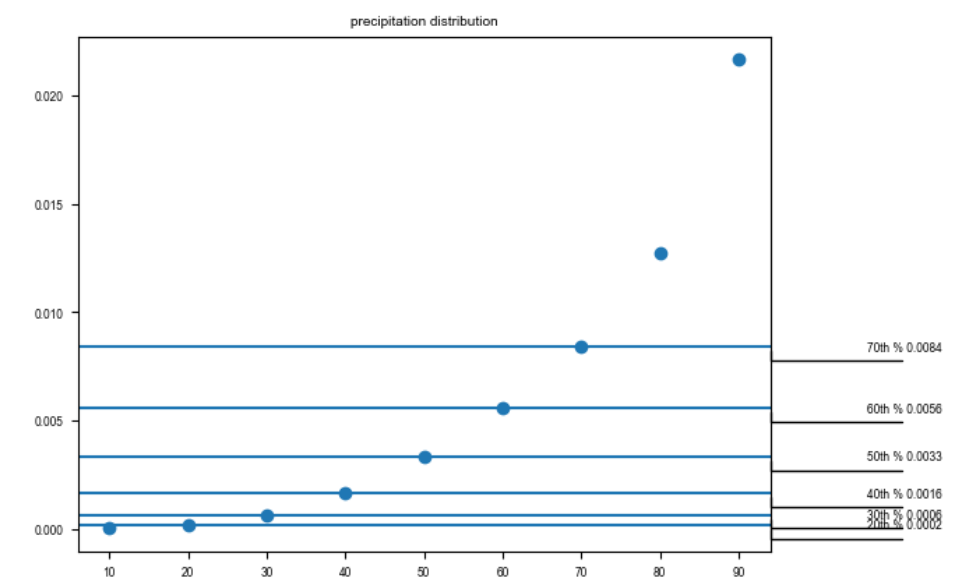

# set group names for kc and ofe

In [ ]:
c = pst.parameter_data.loc[:,'parnme'].str.startswith('kc_')
pst.parameter_data.loc[c,'pargp'] = 'fmp_kc'

c = pst.parameter_data.loc[:,'parnme'].str.startswith('ofe_')
pst.parameter_data.loc[c,'pargp'] = 'fmp_ofe'

c = pst.parameter_data.loc[:,'parnme'].str.startswith('kc_sfac')
pst.parameter_data.loc[c,'pargp'] = 'fmp_sfac'

c = pst.parameter_data.loc[:,'parnme'].str.startswith('ghbk')
pst.parameter_data.loc[c,'pargp'] = 'ghbk'

c = pst.parameter_data.loc[:,'parnme'].str.startswith('rurfac')
pst.parameter_data.loc[c,'pargp'] = 'rurfac'

In [ ]:
pst.parameter_data.query("pargp=='pargp'")

# set parvalues and bounds for sfr, kc, ofe, sfac

In [ ]:
par = pst.parameter_data

par = forward_run.set_laymult_start_values(par)

In [ ]:
importlib.reload(forward_run)

In [ ]:
parbounds = forward_run.get_parbounds()
parbounds

In [ ]:
for k in parbounds.keys():
    c = pst.parameter_data.loc[:,'pargp'] == k
    print(c.sum(), k)
    pst.parameter_data.loc[c,['parlbnd','parubnd', 'parval1']] = parbounds[k]

#set OFE_VINEYARD to 0.95
c = pst.parameter_data.loc[:,'parnme'] == 'ofe_vineyard'
print(c.sum(),'ofe_vineyard')
pst.parameter_data.loc[c,['parval1']] = 0.95


In [ ]:
pst.parameter_data.pargp.value_counts()

# use old parameter values to set initial values for this run

In [ ]:
# old_pars = pd.read_csv(os.path.join("C:\GSP\sv\model\pest_inputs\PEST_PP\pestaws_hyper", 'blaze.2.par.csv'), index_col = [0])
# old_pars = old_pars.loc[['base']].T
# print(old_pars.index.isin(par.parnme).sum())

# old_pars = old_pars.rename(lambda x: x.split("_zone:")[0]+"_zone:1" if '_zone:' in x else x )
# print(old_pars.index.isin(par.parnme).sum())
# print('parameters in old run that are not in this one')
# print(display(old_pars.loc[~old_pars.index.isin(par.parnme)]))

# #drop missing parameters
# old_pars = old_pars.loc[old_pars.index.isin(par.parnme)]

In [ ]:
# old_pars.query("index.str.contains('laymult')").rename(lambda x:''.join(x.split('_')[1:]))

In [ ]:
# old_pars

In [ ]:
# pst.parameter_data.loc[old_pars.index,'parval1'] = old_pars.rename(columns = {'base':'parval1'})

In [ ]:
# pst.parameter_data.loc[old_pars.index,'parval1']

In [ ]:
skip_reset_from_all_pp_to_zonepplaymult = False
if skip_reset_from_all_pp_to_zonepplaymult:
    print('asdfasdf')
    # set layer mult to average of group value, then set pilot point value as multiplier to that to get local differences
    par.loc[old_pars.index,'parval1'] = old_pars.loc[:,'base']
    
    pval_list = list()
    for val in ['ss', 'sy', 'hk', 'vk', 'drn_k','fmp_vk']:
        for i in range(1,7):
            p = f"{val}{i}"
            c = par.loc[:,'pargp']==p
    
            if c.sum()==0:
                pass
            else:
                mean = par.loc[c,'parval1'].mean()
                print(p,c.sum(),mean)
                par.loc[par.loc[:,'parnme']==f"laymult_{val}",'parval1'] = mean
        
                par.loc[c,'parval1'] = par.loc[c,'parval1']/mean
                pval_list.append(par.loc[c,'parval1'].describe().to_frame(p).T)
    
        # do drn_vk, fmp_vk
        p = f"{val}"
        c = par.loc[:,'pargp']==p
    
        if c.sum()==0:
            pass
        else:
            mean = par.loc[c,'parval1'].mean()
            print(p,c.sum(),mean)
            par.loc[par.loc[:,'parnme']==f"laymult_{val}",'parval1'] = mean
    
            par.loc[c,'parval1'] = par.loc[c,'parval1']/mean
            pval_list.append(par.loc[c,'parval1'].describe().to_frame(p).T)
    
    
    pd.concat(pval_list)
    
    def is_numeric(s):
        try:
            float(s)  # Try to convert the string to a float
            return True
        except ValueError:
            return False
    
    assert pst.parameter_data.loc[pst.parameter_data.pargp.apply(is_numeric)].shape[0]==0, 'some pargp values have been turned numeric'

In [ ]:
pst.parameter_data.parlbnd.min()

In [ ]:


# a = pp_cells * ml.dis.delr.array[0] * 3.0
# v = pyemu.geostats.ExpVario(contribution=1.0,a=a)
# gs = pyemu.geostats.GeoStruct(variograms=v,transform="log")
# gs.plot()

# pp_groups = pp_df.groupby("pargp").groups
# for pargp,par_names in pp_groups.items():
#     this_pp_df = pp_df.loc[par_names,:]
#     cov = gs.covariance_matrix(this_pp_df.x,this_pp_df.y,this_pp_df.index)
#     pyemu.helpers.first_order_pearson_tikhonov(pst,cov,reset=False,abs_drop_tol=0.2)

## set param bounds to those already set from pilot points (changing bounds only)

In [ ]:
print(f"these are the unique pargroups { pst.parameter_data.pargp.unique()}")

In [ ]:
importlib.reload(forward_run)

In [ ]:
bounds = forward_run.get_bounds()
bounds

In [ ]:
importlib.reload(forward_run)

# set zone and pilot point mult limits


In [ ]:
zone_bounds = forward_run.get_zone_bounds()

#set pilot point values
for k in zone_bounds.keys():
    c = pst.parameter_data.loc[:,'pargp'] == k
    print(c.sum(), k)
    pst.parameter_data.loc[c,['parlbnd','parubnd','parval1']] = zone_bounds[k]
    
rep = lambda s: re.sub(r'\d+', '', s)

#set zone_mult values
for k in zone_bounds.keys():
    filt = f'zonemult_{rep(k)}'
    c = pst.parameter_data.loc[:,'pargp'] == filt
    print(c.sum(), filt)
    pst.parameter_data.loc[c,['parlbnd','parubnd','parval1']] = zone_bounds[k]
    

In [ ]:
pst.parameter_data.loc[:,'pargp'].unique()

In [ ]:
pst.parameter_data.query("pargp.str.contains('zonemult_hk')")

# fix the sy values if they haven't been removed


In [ ]:
pst.parameter_data.loc[pst.parameter_data.loc[:,'pargp'].str.contains('sy'),'partrans'] = 'fixed'

In [ ]:
pst.parameter_data.loc[pst.parameter_data.loc[:,'pargp'].str.contains('sy'),:]

In [ ]:
pst.parameter_data.loc[pst.parameter_data.pargp=='fmp_kc', 'parval1'] = 1.
pst.parameter_data.loc[pst.parameter_data.pargp=='fmp_sfac', 'parval1'] = 1.

In [ ]:
pst.parameter_data.query("pargp=='fmp_kc'")

In [ ]:
pst.parameter_data.query("pargp=='fmp_sfac'")

In [ ]:
pst.parameter_data.loc[pst.parameter_data.query("parnme.str.contains('zonemult_drn_k_highlands')").index, 'parval1'] = 50

In [ ]:
pst.parameter_data.query("pargp.str.contains('mult_drn_k')")

In [ ]:
summary = pst.write_par_summary_table(filename="par.xlsx", report_in_linear_space = True)

In [ ]:
summary.sort_values('upper bound')

# set parval for some of the zonemults

In [ ]:
importlib.reload(forward_run)

In [ ]:
pst.parameter_data = forward_run.set_zonemult_start_values(pst.parameter_data)

In [ ]:
pst.parameter_data = forward_run.set_zoneentire_start_values(pst.parameter_data)

In [ ]:
pst.parameter_data.loc[pst.parameter_data.parval1.isnull()].pargp.unique()

In [ ]:
assert pst.parameter_data.parval1.isnull().sum()==0, f"there are {pst.parameter_data.parval1.isnull().sum()} parvalues with nans from {pst.parameter_data.loc[pst.parameter_data.parval1.isnull()].pargp.unique()}"

In [ ]:
pst.parameter_data.loc[pst.parameter_data.parlbnd==1.1e-10]

In [ ]:
assert (pst.parameter_data.parlbnd.min()>1.1e-10) & (pst.parameter_data.parlbnd.max()<1.1e+10), pst.parameter_data.query("parlbnd==1e-10")

# set observations with -999 as zero weights

In [ ]:
pst.observation_data

In [ ]:
print(f"number of non-zero observations before filtering for obs <=-999:\n {len(pst.nnz_obs_names)}")

pst.observation_data.loc[pst.observation_data.loc[:,'obsval']<=-999, 'weight'] = 0.0
print(f"after:\n {len(pst.nnz_obs_names)}")

In [ ]:
pst.observation_data.loc[pst.observation_data.loc[:,'obsval']<=-999].obgnme.value_counts()

In [ ]:
pst.observation_data.query("obsnme.str.contains('son0170') and weight==0").obgnme.unique()

In [ ]:
pst.observation_data.loc[pst.observation_data.loc[:,'obsval']<=-999]

In [ ]:
obs = pst.observation_data
# obs.loc[:,"standard_deviation"] = np.nan
hds_obs = [o for o in pst.nnz_obs_names if "oname:hds_" in o]
assert len(hds_obs) > 0
obs.loc[hds_obs,"standard_deviation"] = 0.5
# hdstd_obs = [o for o in pst.nnz_obs_names if "oname:hdstd_" in o]
# assert len(hdstd_obs) > 0
# obs.loc[hdstd_obs,"standard_deviation"] = 0.01

# sfr_obs = [o for o in pst.nnz_obs_names if "oname:sfr_" in o]
# assert len(sfr_obs) > 0
# # here we will used noise that is a function of the observed flow value so that 
# # when flow is high, noise is high.
# obs.loc[sfr_obs,"standard_deviation"] = 1.0 / (obs.loc[sfr_obs,"obsval"] * 0.2)
# # sfrtd_obs = [o for o in pst.nnz_obs_names if "oname:sfrtd_" in o]
# # assert len(sfrtd_obs) > 0
# # obs.loc[sfrtd_obs,"standard_deviation"] = 1.0 / (obs.loc[sfrtd_obs,"obsval"] * 0.2)
# obs.loc[obs.loc[:,"standard_deviation"]>50, "standard_deviation"] = 50

In [ ]:
obs.loc[obs.loc[:,'obsnme'].isnull()]

# adding zone names to head `hds` measurements

In the next few cells we are going to make use of `flopy` and some of the metadata that `pyemu.PstFrom` recorded when constructing our PEST(++) setup to calculate distances between parmaters and observations. We will do this only for groundwater level observations.

In [ ]:
hds_df.head()

In [ ]:
hds_df.loc[:,'station'] = hds_df.obsnme.apply(lambda x: x.replace("oname:hds_otype:lst_usecol:simulatedequivalent_observationname:",'').split('_date')[0])

hds_df.loc[:,'date'] = hds_df.loc[:,'obsnme'].apply(lambda x: x.split('_date:')[-1])

In [ ]:
hds_ob = pd.read_csv(os.path.join(template_ws,'output', 'SV_HOBS_all._os'), sep = '\s+')
hds_ob.loc[:,'station'] = hds_ob.loc[:,'OBSERVATIONNAME'].str.lower()
hds_ob = hds_ob.rename(columns = {"DATE":'date'}).loc[:,['date','station', 'OBSERVEDVALUE']]
hds_ob

In [ ]:
hds_df = pd.merge(hds_df, hds_ob, left_on = ['station', 'date'], right_on = ['station', 'date'])

In [ ]:

gwstats =  pd.read_excel(r"C:\GSP\sv\model\update_2024\scripts\HOB_Creation\WellDetails_20240911.xlsx")
gwstats.loc[:,'nlayers'] = (gwstats.filter(regex = 'Layer_')>0).sum(axis = 1)-1
gwstats.loc[:,'station_name'] = gwstats.station_name.str.lower()


## load zone info

In [ ]:


z = np.genfromtxt(os.path.join(ml.model_ws, 'model_arrays', 'zonation_3.csv'), delimiter = ' ')

z = conda_scripts.arich_functions.array2rc(z,'zone').astype({'zone':int,'row':int,'column':int})

aliases = {1: 'Bay', 2: 'EastSide', 3: 'SouthCent', 4: 'Kenwood', 5: 'VOM', 6: 'AguaCal',7:'WestSide',8:'CitySon',9:'Highlands'}
z.loc[:,'zone'] =z.loc[:,'zone'].replace(aliases)
z = z.query("zone!=0").loc[:,['row','column','zone']]

z


In [ ]:
assert hds_df.station.isin(gwstats.station_name).all(), f"the following station are not in gsstats\n{hds_df.station.isin(gwstats.station_name).unique()}"

In [ ]:
hds_df  = hds_df.drop(columns = [x for x in ['station_name', 'Row','Col', 'nlayers', 'RMP', 'row', 'column', 'zone'] if x in hds_df.columns] )
hds_df = pd.merge(hds_df, gwstats.loc[:,['station_name', 'Row','Col', 'nlayers', 'RMP']], left_on = 'station', right_on = 'station_name',how = 'left')

hds_df = pd.merge(hds_df, z, left_on = ['Row', 'Col'], right_on = ['row', 'column']).drop(columns = ['row', 'column'])

# make group for RMP sites

In [ ]:
c = hds_df.query("RMP=='Y'").index
hds_df.loc[c,'obgnme'] = 'hds_RMP_'+hds_df.loc[c,'zone'].str.lower()


c = hds_df.query("RMP!='Y'").index
hds_df.loc[c,'obgnme'] = 'hds_NON_'+hds_df.loc[c,'zone'].str.lower()

### adjust weights depending on nlayers

In [ ]:
hds_df.loc[:,'weight'] = hds_df.nlayers.apply(lambda x: 1. if x<=2 else 0.5 )

In [ ]:
hds_df.loc[:,'standard_deviation'] = 1.0

In [ ]:
hds_df.loc[:,['RMP','zone','weight']].groupby(['zone','RMP',]).sum().unstack().fillna(0).droplevel(0,1).plot.bar(title = "Number of Measuremets per Zone")

plt.savefig('hds_measurements_per_zone.png', dpi = 250)

In [ ]:
hds_df.index = hds_df.obsnme

In [ ]:
hds_df

In [ ]:
pst.observation_data.loc[hds_df.index,["obsval","weight","obgnme", 'standard_deviation']] = hds_df.loc[:,["OBSERVEDVALUE","weight","obgnme", 'standard_deviation']].rename(columns = {'OBSERVEDVALUE':'obsval'})

In [ ]:
pst.observation_data.loc[hds_df.index,:]

In [ ]:
pst.observation_data.loc[pst.observation_data.obsval.isnull(),'obgnme']

In [ ]:
assert pst.observation_data.loc[pst.observation_data.obsval.isnull()].shape[0]==0, pst.observation_data.loc[pst.observation_data.obsval.isnull(),'obgnme'].value_counts()

In [ ]:
assert pst.observation_data.loc[pst.observation_data.weight.isnull()].shape[0]==0, pst.observation_data.weight.isnull().sum()

In [ ]:
assert pst.observation_data.query("standard_deviation.isnull() and weight>0").shape[0]==0, pst.observation_data.query("standard_deviation.isnull() and weight==0")

In [ ]:
assert pst.observation_data.query("obgnme=='hds'").observationname.nunique()==0, f'there are still observation data with group name==hds'

In [ ]:
# set these two stations observed avlues to zero

In [ ]:
badin = pst.observation_data.query("obsnme.str.contains('son0170') & obgnme.str.contains('hds') ").index
pst.observation_data.loc[badin,'weight'] = 0
badin = pst.observation_data.query("obsnme.str.contains('son0334') & obgnme.str.contains('hds') ").index
pst.observation_data.loc[badin,'weight'] = 0

badin = pst.observation_data.query("obsnme.str.contains('son0085') & obgnme.str.contains('hds') ").index
pst.observation_data.loc[badin,'weight'] = 0

# set SMC stations to groups

In [ ]:
pst.observation_data.columns

In [ ]:
pst.observation_data.query("obgnme=='hds'").observationname.nunique()

# summarize observations


In [ ]:
summary_obs = pst.write_obs_summary_table(filename="obs.xlsx")
summary_obs.loc[summary_obs.weight=='    1']

In [ ]:
display(summary_obs)

In [ ]:
pst.observation_data

In [ ]:
pst.observation_data.obgnme.unique()

In [ ]:
out_folder = os.path.join('pre_process', template_ws,'hydros')

os.makedirs(out_folder,exist_ok=True)




In [ ]:
assert pst.observation_data.query("obgnme.str.contains('_log') and obgnme.str.contains('aguacal')").shape[0]>=586      , "missing values from aguacal in sfr log"
assert pst.observation_data.query("obgnme.str.contains('_log') and obgnme.str.contains('kenwood')").shape[0]>=586  , "missing values from kenwood in sfr log"


obs = pst.observation_data.copy()

if obs.query("obgnme.str.contains('aguacal_log')").shape==obs.query("obgnme.str.contains('aguacal_log') and not obsnme.str.contains('fdc')").shape:
    print('agual_log does not contain fdc or other mislabeld variables')
else:
    print('bad\n'*3+'agual_log DOES contain fdc or other mislabeld variables')

if obs.query("obgnme.str.contains('kenwood_log')").shape==obs.query("obgnme.str.contains('kenwood_log') and not obsnme.str.contains('fdc')").shape:
    print('kenwood_log does not contain fdc or other mislabeld variables')
else:
    print('bad'*3+'------->> kenwood_log DOES contain fdc or other mislabeld variables')
    
sfr = obs.query("obgnme.str.contains('aguacal_log')")
sfr.loc[:,'date'] = pd.to_datetime(sfr.obsnme.apply(lambda x:x.split("_date:")[-1]))
ax = sfr.query("weight>0").set_index('date').loc[:,['obsval']].resample("1M").mean().reset_index().plot(x = 'date', y = 'obsval',marker = 'o')
ax2 = ax.twinx()
sfr.query("weight>0").set_index('date').loc[:,['weight']].resample("1M").mean().reset_index().plot(x = 'date', y = 'weight',marker = 'o',ax = ax2, c = 'g')
ax2.set_ylim([None, .4])
ax.set_title('Agua Caliente Discharge Observations')
ax.set_ylabel("log(CFS)")
plt.savefig(os.path.join(out_folder, 'sfr_flow_agua_cal.png'), dpi =250, bbox_inches = 'tight')

sfr = obs.query("obgnme.str.contains('kenwood_log') and not obgnme.str.contains('fdc') and not obsnme.str.contains('fdc')")
sfr.loc[:,'date'] = pd.to_datetime(sfr.obsnme.apply(lambda x:x.split("_date:")[-1]))
ax = sfr.query("weight>0").set_index('date').loc[:,['obsval']].resample("1M").mean().reset_index().plot(x = 'date', y = 'obsval',marker = 'o')
ax2 = ax.twinx()
sfr.query("weight>0").set_index('date').loc[:,['weight']].resample("1M").mean().reset_index().plot(x = 'date', y = 'weight',marker = 'o',ax = ax2, c = 'g')
ax2.set_ylim([None, .4])
ax.set_title('Kenwood Discharge Observations')
ax.set_ylabel("log(CFS)")
plt.savefig(os.path.join(out_folder, 'sfr_flow_kenwood.png'), dpi =250, bbox_inches = 'tight')



In [ ]:
pst.observation_data.query("obgnme.str.contains('sfr_wy_min_flow_')")

In [ ]:
pst.observation_data.query("obgnme.str.contains('sfr_wy_min_flow_') and obgnme.str.contains('kenwood')").shape

In [ ]:
assert pst.observation_data.query("obgnme.str.contains('yearly_min_flow') and obgnme.str.contains('agua')").shape[0]>=19      , "missing values from aguacal in sfr_wy_min_flow_"
assert pst.observation_data.query("obgnme.str.contains('yearly_min_flow') and obgnme.str.contains('kenwood')").shape[0]>=10  , "missing values from kenwood in sfr_wy_min_flow_"


obs = pst.observation_data.query("obgnme.str.contains('yearly_min_flow') and obgnme.str.contains('agua')")

    
sfr = obs.query("obgnme.str.contains('agu')")
sfr.loc[:,'date'] = pd.to_datetime(sfr.obsnme.apply(lambda x:x.split("_date:")[-1]))
ax = sfr.query("weight>0").plot(x = 'date', y = 'obsval', marker = 'o', ls = '')

ax.set_title('Agua Caliente Minimum Flow per Water Year')
ax.set_ylabel("log(CFS)")
plt.savefig(os.path.join(out_folder, 'sfr_min_flow_agua_cal.png'), dpi =250, bbox_inches = 'tight')


obs = pst.observation_data.query("obgnme.str.contains('yearly_min_flow') and obgnme.str.contains('ken')")

sfr = obs.query("obgnme.str.contains('ken')")
sfr.loc[:,'date'] = pd.to_datetime(sfr.obsnme.apply(lambda x:x.split("_date:")[-1]))
ax = sfr.query("weight>0").plot(x = 'date', y = 'obsval', marker = 'o', ls = '')

ax.set_title('Kenwood Minimum Flow per Water Year')
ax.set_ylabel("log(CFS)")
plt.savefig(os.path.join(out_folder, 'sfr_min_flow_kenwood.png'), dpi =250, bbox_inches = 'tight')

In [ ]:
assert pst.observation_data.query("obgnme.str.contains('fdc') and obgnme.str.contains('agua')").shape[0]>=19      , "missing values from aguacal in fdc"
# assert pst.observation_data.query("obgnme.str.contains('fdc') and obgnme.str.contains('kenwood')").shape[0]>=19  , "missing values from kenwood in fdc"


obs = pst.observation_data.query("obgnme.str.contains('fdc') and obgnme.str.contains('agu')").copy()
sfr = obs.query("obgnme.str.contains('agu')")

sfr = sfr.astype({'percentile':float}).sort_values('percentile')
ax = sfr.query("weight>0").plot(x = 'percentile', y = 'obsval', marker ='.')
ax.set_title('Agua Caliente Flow Duration Curve')
ax.set_ylabel("log(CFS)"); ax.grid(True)
# plt.savefig(os.path.join(out_folder, 'sfr_min_flow_agua_cal.png'), dpi =250, bbox_inches = 'tight')


obs = pst.observation_data.query("obgnme.str.contains('fdc') and obgnme.str.contains('ken')")
sfr = obs.query("obgnme.str.contains('ken')")
sfr = sfr.astype({'percentile':float}).sort_values('percentile')
ax = sfr.query("weight>0").plot(x = 'percentile', y = 'obsval', marker ='.')
ax.set_title('Kenwood Flow Duration Curve')
ax.set_ylabel("log(CFS)"); ax.grid(True)
# plt.savefig(os.path.join(out_folder, 'sfr_min_flow_kenwood.png'), dpi =250, bbox_inches = 'tight')




In [ ]:
out_folder

In [ ]:
# hds =  pst.observation_data.query("obgnme.str.contains('hds') or obgnme.str.contains('gwle') or obgnme.str.contains('roll')").copy()
# hds.loc[:,'date'] = pd.to_datetime(hds.obsnme.apply(lambda x:x.split("_date:")[-1]))

# hds.loc[:,'station'] = hds.obsnme.apply(lambda x: x.split(':')[4].split(':')[0].replace('_date',''))

# for station, group in hds.groupby('station'):

#     if group.query("obgnme.str.contains('gwle_abs')").shape[0]>0:
#         ax = group.query("obgnme.str.contains('gwle_abs')").plot(x = 'date', y = 'obsval', label = 'gwle_abs - modeled')
#         # group.query("Group.str.contains('gwle_abs')").plot(x = 'date', y = 'Measured', ax = ax, label = "gwle_abs - 'Observed'")
#     if group.query("obgnme.str.contains('hds')").shape[0]>0:
#         if ax is None:
#             fig, ax = plt.subplots()
#         group.query("obgnme.str.contains('hds')").plot(x = 'date', y = 'obsval', ax = ax,  marker = 'o', label = 'hds - modeled')
#         # group.query("obgnme.str.contains('hds')").plot(x = 'date', y = 'Measured',  ax = ax, marker = 'o',label = 'hds - Observed')

#     if group.query("obgnme.str.contains('roll_')").shape[0]>0:
#         if ax is None:
#             fig, ax = plt.subplots()
#         group.query("obgnme.str.contains('roll_') and weight>0").plot(x = 'date', y = 'obsval', ax = ax,  mfc = 'w',
#                                                             marker = 'o', label = 'gwle roll - modeled')
#         # group.query("Group.str.contains('gwle_roll')").plot(x = 'date', y = 'Measured',  ax = ax,mfc = 'w',
#         #                                                     marker = 'o',label = 'gwle roll - Observed')
        
#     print(station+' '+ group.obgnme.unique()[0].split("_")[-1])
#     ax.set_title(station+' '+ group.obgnme.unique()[0].split("_")[-1])

#     plt.savefig(os.path.join(out_folder, station+'.png'))
#     ax = None

In [ ]:
pst.observation_data.query("obgnme=='flux'")

# obsgrps with zero-weights

In [ ]:
summary_obs.query("`zero weight`>0")

# auto-correlated (t)errors

if not 'pst' in locals():

    pst = pyemu.Pst(os.path.join("C:\GSP\sv\model\pest_inputs\PEST_PP\pestaws_V2_output","blast.pst"))

# extend bounds of parameters at bounds

In [ ]:
ind = pst.parameter_data.query("parval1==parubnd").index
pst.parameter_data.loc[ind,'parubnd'] = pst.parameter_data.loc[ind,'parubnd']*100
print(f"num at parubnd {ind.shape[0]}")
ind = pst.parameter_data.query("parval1==parlbnd").index
pst.parameter_data.loc[ind,'parlbnd'] = pst.parameter_data.loc[ind,'parlbnd']*0.01
print(f"num at parlbnd {ind.shape[0]}")


# add parameter correlations and create input ensembles

In [ ]:
pp_tpl = [os.path.join(template_ws, 'pp2024',x) for x in os.listdir(os.path.join(template_ws, 'pp2024',)) if '.tpl' in x]
pp_tpl

In [ ]:

cov = pyemu.helpers.geostatistical_prior_builder(pst=pst, struct_dict={gs:pp_tpl})

In [ ]:
# # display
# plt.imshow(cov.to_pearson().x,interpolation="nearest")
# plt.colorbar()
# cov.to_dataframe().head()

In [ ]:
ies_num_reals = 150

In [ ]:
parensemble = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst, cov=cov, num_reals=ies_num_reals,)
# ensure that the samples respect parameter bounds in the pst control file
parensemble.enforce()

In [ ]:
parensemble.head()

In [ ]:
ies_num_reals

In [ ]:
parensemble.to_csv(os.path.join(template_ws,"par_ens.csv"))



In [ ]:
def set_pst(obj):
    obj.enforce_bounds()
    obj.pestpp_options["ies_num_reals"] = ies_num_reals  # starting with a real small ensemble!
    obj.pestpp_options['ies_parameter_ensemble'] = 'par_ens.csv'
    obj.pestpp_options["svd_pack"] = "redsvd"
    obj.pestpp_options["panther_agent_restart_on_error"] = True
    obj.pestpp_options['overdue_giveup_fac'] =  6
    obj.pestpp_options['overdue_giveup_minutes'] =480
    obj.control_data.noptmax = -2
    obj.control_data.phiredstp = 1e-10  # just to make sure this doesn't stop the run which has happened
    obj.model_command =[ 'python forward_run.py']
    obj.model_command = ['run.bat']
    obj.pestpp_options['ies_drop_conflicts'] = True
    obj.pestpp_options["ies_bad_phi_sigma"] = 1.5 #middle ground value

set_pst(pst)

In [ ]:
def run_major_pst(obj):
    obj.enforce_bounds()
    obj.pestpp_options["ies_num_reals"] = ies_num_reals  # starting with a real small ensemble!
    obj.pestpp_options['ies_parameter_ensemble'] = 'par_ens.csv'
    obj.pestpp_options["svd_pack"] = "redsvd"
    obj.pestpp_options["panther_agent_restart_on_error"] = True
    obj.pestpp_options['overdue_giveup_fac'] =  6
    obj.pestpp_options['overdue_giveup_minutes'] =480
    obj.pestpp_options['ies_subset_size'] =-10
    obj.pestpp_options['ies_multimodal_alpha'] = 0.2
    obj.pestpp_options['ies_drop_conflicts'] = True
    obj.control_data.noptmax = 30
    obj.control_data.phiredstp = 1e-20  # just to make sure this doesn't stop the run which has happened
    obj.model_command =[ 'python forward_run.py']

    obj.pestpp_options["ies_bad_phi_sigma"] = 1.5 #middle ground value


- Some of the iterations were “rejected” meaning the full ensemble phi was much higher than the subset phi. So I’d change ies_subset_size to -10, which means use 10% of the active realizations for subset testing.  This usually means the inverse problem is more nonlinear than usual.   
- Several of the parameter’s initial values are at the bound.  This can make the gradient approximation a lil goofy.  I wonder if you could either move the initial value off of the bound or widen the bounds?   
- For the next run, would you be ok setting the ML groundwater level obs to zero weight?  Sometimes when you have heaps of non-zero weight observations, it can inflate the dimensions of the solution space, making it harder for ensemble methods to fit all the data.   
- Also for the next run, can you set ies_multimodal_alpha = 0.2.  This will trigger ies to use a more aggressive solution that is better in highly nonlinear settings.   
- Let’s also set ies_bad_phi_sigma = 1.5 (which will more aggressively remove poor performing realizations)



In [ ]:
pre_run = pst.parameter_data.copy()

In [ ]:
pst.write(os.path.join(template_ws, 'lager.pst'),version=2)

In [ ]:
template_ws

In [ ]:
asdf

In [ ]:
pst.adjust_weights(obsgrp_dict =balanced_groups)

## Observation Weights

Of all the issues that we have seen over the years, none is greater than (in)appropriate weighting strategies.  It is a critical and fundamental component of any inverse problem, but is especially important in settings where the model is imperfect simulator and the observation data are noisy and there are diverse types of data.  Goundwater modeling anyone? 

In essence the weights will change the shape of the objective function surface in parameter space, moving the minimum around and altering the path to the minimum (this can be seen visually in the response surface notebooks).  Given the important role weights play in the outcome of a history-matching/data assimilation analysis, rarely is a weighting strategy "one and done", instead it is continuously revisited during a modeling analysis, based on what happened during the previous history-matching attempt.  

We are going to start off by taking a look at our current objective function value and the relative contributions from the various observation groups - these relative contributions are a function of the residuals and weights in each group. Recall that this is the objective function value with **initial parameter values** and the default observations weights.

First off, we need to get PEST to run the model once so that the objective function can be calculated. Let's do that now. Start by reading the control file and checking that NOPTMAX is set to zero:



In [ ]:
# template_ws = 'pestaws_mango'

# set weights

In [ ]:
pst_out = pyemu.Pst(os.path.join(template_ws, 'leo.pst'), resfile = os.path.join('pestaws_lager','lager.mean.rei'))
pst_out.phi

In [ ]:
pst_out = pyemu.Pst(os.path.join(template_ws, 'lager.pst'), resfile = os.path.join(template_ws,'lager.mean.rei'))
pst_out.phi

In [ ]:
"{:.5g}".format(pst_out.phi)

In [ ]:
frac_sfr_obs = pst_out.observation_data.query("obgnme=='kenwood_log' & weight>0").shape[0]/pst_out.observation_data.query("obgnme=='aguacal_log' & weight>0").shape[0]

In [ ]:
frac_sfr_obs

# setting only wells within important wells list to non-zero weights

In [ ]:
obs = pst_out.observation_data.copy()

#if you want to include `hds` obsertvations (and not just GWLE) then uncomment these lines
# c = obs.observationname.notnull() & obs.obgnme.str.contains('hds')
# print(c.sum())
# obs.loc[c,'station'] = obs.loc[c,'observationname'].str.lower()

In [ ]:
import geopandas as gpd
imp_wells = gpd.read_file(os.path.join('..\\waterlevel\\important_hydros', 'very_important_wells.shp'))

imp_wells.loc[:,'station'] = imp_wells.loc[:,'Station Na'].str.lower()
print(','.join(imp_wells.station.values))

important_obs = obs.loc[obs.station.str.lower().isin(imp_wells.station)]

vcount = important_obs.obgnme.value_counts().to_frame('n').reset_index()
vcount.loc[:,'obgnme'] = vcount.loc[:,'obgnme'].str.replace('_non_','_non_na_').str.replace('_rmp_','_rmp_na_')
vcount = vcount.obgnme.str.split('_',expand = True).join(vcount)
vcount.columns = ['group', 'deriv', 'depth','zone', 'obgnme','n']
vcount.groupby(['zone',  'deriv']).sum().loc[:,['n']].unstack().droplevel(0,1).plot.bar(title = 'Number of measurements per group for simple run with only GWLE obs')


In [ ]:
pst_out.observation_data.loc[:,'weight'] = 0

pst_out.observation_data.loc[important_obs.index,'weight'] = 1

pst_out.observation_data.loc[important_obs.query("obgnme.str.contains('gwle_major') & obsval>0").index,'weight'] = 0
pst_out.observation_data.loc[important_obs.query("obgnme.str.contains('gwle_major') & obsval<-0").index,'weight'] = 1.
pst_out.observation_data.loc[important_obs.query("obgnme.str.contains('gwle_major') & obsval<-50").index,'weight'] = 2.
pst_out.observation_data.loc[important_obs.query("obgnme.str.contains('gwle_major') & obsval<-100").index,'weight'] = 3.
## this is for the test of looking at only the 20 or so wells

# create a dictionary of group names and weights
contrib_per_group = 1e10/ float(len(pst_out.nnz_obs_groups))
balanced_groups = {grp:contrib_per_group for grp in pst_out.nnz_obs_groups}

for locs in ['gwle_abs_']:
    balanced_groups = { key:(value*.5 if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in ['ddown']:
    balanced_groups = { key:(value*1 if locs in key
              else value) for key, value in balanced_groups.items() }
    
for locs in ['roll']:
    balanced_groups = { key:(value*1 if locs == key
              else value) for key, value in balanced_groups.items() }

for locs in ['roll18']:
    balanced_groups = { key:(value*2 if locs in key
              else value) for key, value in balanced_groups.items() }

# make all non-zero weighted groups have a contribution of 100.0
pst_out.adjust_weights(obsgrp_dict=balanced_groups,)

run_major_pst(pst_out)


pst_out.write(os.path.join('pestaws_lager', 'lager.pst'),version=2)

In [ ]:
df = conda_scripts.utils.get_russian_riv_flows.get_usgs()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Create subplot grid
# fig = make_subplots(rows=2, cols=2)
# fig.add_trace(row=1,col=1)
fig = px.line(x= [1,1], y = [2,2], color = ['r']*2)
fig.show()
fig = [fig]

fin = go.Figure()

for f in fig:
    for g in f.data:
        fin.add_trace(g)

fin.show()

In [ ]:
vcount = pd.Series(balanced_groups).to_frame('phi').reset_index().rename(columns = {'index':'obgnme'})


vcount.loc[:,'obgnme'] = vcount.loc[:,'obgnme'].str.replace('_non_','_non_na_').str.replace('_rmp_','_rmp_na_')
vcount = vcount.obgnme.str.split('_',expand = True).join(vcount)
vcount.columns = ['group', 'deriv', 'depth','zone', 'obgnme','n']
vcount.groupby(['zone',  'deriv']).sum().loc[:,['n']].unstack().droplevel(0,1).plot.barh(title = 'Contribution to Phi Per Group')

In [ ]:
[x  for x in pst.observation_data.obgnme.unique() if not x.lower() in pst_out.nnz_obs_groups]

In [ ]:
# create a dictionary of group names and weights
contrib_per_group = pst_out.phi / float(len(pst_out.nnz_obs_groups))
balanced_groups = {grp:contrib_per_group for grp in pst_out.nnz_obs_groups}


# balanced_groups['kenwood_log'] = balanced_groups['kenwood_log']
balanced_groups['aguacal_log'] = balanced_groups['aguacal_log']*3

balanced_groups['kenwood_log'] = balanced_groups['aguacal_log']*frac_sfr_obs
# {x:v*3 if 'eside' in x else x:v for x,v in balanced_groups.items()}

for locs in ['hk', 'irr_dept']:
    balanced_groups = { key:(value*2 if locs in key
              else value) for key, value in balanced_groups.items() }


for locs in ['eastside','_aguacal']:
    balanced_groups = { key:(value*5 if (locs in key) 
                             and (not 'sfr' in key) 
                             and (not 'log' in key) 
                             and (not 'min_flow' in key)
                             
              else value) for key, value in balanced_groups.items() }

for locs in ['major']:
    balanced_groups = { key:(value*5 if locs in key
              else value) for key, value in balanced_groups.items() }
    
for locs in ['rmp']:
    balanced_groups = { key:(value*10 if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in ['hds_non']:
    balanced_groups = { key:(value*1 if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in ['gwle_ddown']:
    balanced_groups = { key:(value*0.25 if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in ['roll']:
    balanced_groups = { key:(value*.5 if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in ['sfr']:
    balanced_groups = { key:(value*.25 if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in ['deep']:
    balanced_groups = { key:(value*1.25 if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in [ 'kenwood']:
    balanced_groups = { key:(value*(0.33) if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in ['highlands']:
    balanced_groups = { key:(value*(0.1) if locs in key
              else value) for key, value in balanced_groups.items() }


# make sure aguacal sfr flows are highest

sf_agua = list(filter(lambda x: 'aguacal' in x and not(( 'gwle' in x) or ( 'hds' in x)), pst_out.observation_data.obgnme.unique()))

mv = max(balanced_groups.values())*.5

for locs in sf_agua:
    balanced_groups = { key:(mv if locs in key
              else value) for key, value in balanced_groups.items() }




# make sure aguacal sfr flows are highest

sf_agua = list(filter(lambda x: 'kenwood' in x and not(( 'gwle' in x) or ( 'hds' in x)), pst_out.observation_data.obgnme.unique()))
mv = max(balanced_groups.values())*frac_sfr_obs*.3

for locs in sf_agua:
    balanced_groups = { key:(mv if locs in key
              else value) for key, value in balanced_groups.items() }

for locs in ['sfr_fdc', 'yearly_min_']:
    balanced_groups = { key:(value*(0.7) if locs in key
              else value) for key, value in balanced_groups.items() }

    
# # set all gwle to zero
# for locs in ['gwle']:
#     balanced_groups = { key:(value*(0.0) if locs in key
#               else value) for key, value in balanced_groups.items() }

In [ ]:
sf_agua

In [ ]:

phicomp_pre = pd.Series({k:pst_out.phi_components[k] for k in pst_out.nnz_obs_groups})


In [ ]:
print((phicomp_pre/phicomp_pre.sum()).sort_values(ascending = False).head(50))

In [ ]:
print((phicomp_pre/phicomp_pre.sum()).sort_values(ascending = False).tail(20))

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
bb = pd.Series(balanced_groups).sort_values()


c = bb.copy()
c = 100*c/c.sum()
c = c.to_frame('label').sort_values(by = 'label', ascending = True)
c.loc[:,'label'] = c.label.apply(lambda x: f"{x:.1f}%")
c.loc[:,'ind'] = np.arange(c.shape[0])
c = c.drop_duplicates('label')
c

def get_color(s):
    if 'hds_rmp' in s:
        return 'green'
    if 'hds_non' in s:
        return 'orange'
    elif 'roll' in s:
        return 'blue'
    elif 'ddown' in s:
        return 'grey'
    elif 'abs' in s:
        return 'c'
    elif "_major" in s.lower():
        return 'purple'
    elif 'sfr' in s or 'min_flow' in s or "_log":
        return 'red'
    else:
        return 'brown'

# Example usage
legend_entries = [
    ("hds_rmp", "green"),
    ("hds_non", "orange"),
    ("roll", "blue"),
    ("ddown", "grey"),
    ("major drawdown", "purple"),
    ("abs", "black"),
    ("streamflow/sfr", "red"),
    ("other", "brown")  # For all other cases
]

colors = bb.index.map(get_color)
ax = bb.plot.barh(figsize = (4,15), color = colors, ec = 'k')
ax.grid(True)

# Create a legend with Patch instead of Polygon
legend_patches = [mpatches.Patch(facecolor =color, label=name, edgecolor = 'k') for name, color in legend_entries]
# Add the legend to the plot
plt.legend(handles=legend_patches, loc='lower right', bbox_to_anchor=(1, 0))

conda_scripts.plot_help.label_outside_multiple(ax, y = c.ind.values, labels = c.label.values, str_format='.1f', already_str=True,zise = "20%" )

# plt.savefig('observation_weights.png', dpi = 250, bbox_inches = 'tight')

In [ ]:
pst.observation_data

In [ ]:
# make all non-zero weighted groups have a contribution of 100.0
pst_out.adjust_weights(obsgrp_dict=balanced_groups,)

In [ ]:
# pst_out.pestpp_options["ies_restart_observation_ensemble"] = 'whiz.0.obs.csv'

In [ ]:
# pst_out.pestpp_options["ies_restart_parameter_ensemble"] = 'whiz.0.par.csv'

In [ ]:
template_ws

In [ ]:
run_major_pst(pst_out)
pst_out.write(os.path.join(template_ws, 'mango.pst'),version=2)

In [ ]:
pst_out.parameter_data

In [ ]:
pst_out.parameter_data.query("parval1==parlbnd or parval1==parubnd")

In [ ]:
phicomp = pd.Series({k:pst_out.phi_components[k] for k in pst_out.nnz_obs_groups})

In [ ]:


phoebe = phicomp.to_frame('post').join(phicomp_pre.to_frame('pre (even weighting)'))

# .plot.bar()

In [ ]:
phoebe

Let's take a look at how that has affected the contributions to Phi:

In [ ]:
template_ws

In [ ]:
pst_out.pestpp_options['overdue_giveup_fac'] =  5
pst_out.pestpp_options['overdue_giveup_minutes'] =6*60

In [ ]:
pst_out.model_command = 'python forward_run.py'
pst_out.control_data.noptmax = 3
pst_out.write(os.path.join(template_ws, 'zoom.pst'),version=2)

The next cell adds in a column to the `pst.observation_data` for checking purposes in subsequent tutorials. In practice, when you have lots of model outputs treated as "obserations" in the pest control file, setting a flag to indicate exactly which observation quantities correspond to actual real-world information can be important for tracking things through your workflow...

### Understanding Observation Weights and Measurement Noise

Let's have a look at what weight values were assigned to our observation groups:

In [ ]:
obs = pst_out.observation_data
for group in pst_out.nnz_obs_groups:
    print(group,f"{obs.loc[obs.obgnme==group,'weight'].max():,.1f}")

# here are the weights that should be set

| Name          | Value |
|:--------------|:------|
| hds           | 28    |
| aguacal_log   | 2783  |
| kenwood_log   | 1556  |

Ok, some variability there, and, as expected, the sfr flowout observations have been given a very low weight and the groundwater level obs have been given a very high weight - this is simply to overcome the difference in magnitudes between these two different data types.  All good...or is it?

In standard deterministic parameter estimation, only the relative difference between the weights matters, so we are fine there...but in uncertainty analysis, we often want to account for the contribution from measurement noise and we havent told any of the pest++ tools not to use the inverse of the weights to approximate measurement noise, and this is a problem because those weights we assigned have no relation to measurement noise!  This can cause massive problems later, especially is you are using explicit noise realizations in uncertainty analysis - Imagine how much SFR flow noise is implied by that tiny weight?  It's easy to see how negative SFR flow noise values might be drawn with that small of a weight (high of a standard deviation) #badtimes.   

So what can we do?  Well there are options.  An easy way is to simply supply a "standard_deviation" column in the `pst.observation_data` dataframe that will cause these values to be used to represent measurement noise.  

In [ ]:
pst_out.control_data.noptmax = 3

In [ ]:
pst_out.write(os.path.join(template_ws, "blaze.pst"),version=2)

In [ ]:



mast = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\master\pest_ies.0.par.csv").set_index('real_name')
temp = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\pestrunv4\pest_ies.0.par.csv").set_index('real_name')

mast = mast.loc[['base']].T
temp = temp.loc[['base']].T

In [ ]:
j = mast.join(temp,rsuffix =  'temp' )
j.loc[:,'ratio'] = j.loc[:,'base']/j.loc[:,'basetemp']
bad = j.loc[j.ratio!=1]
pd.Series(bad.index.map(lambda x:x[0:3])).unique()

In [ ]:
### saving the new control file

In [ ]:
mast = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\master\pest_ies.par_data.csv")
temp = pd.read_csv(r"C:\GSP\sv\model\update_2024\scripts\pestrunv2\pest_ies.par_data.csv")

In [ ]:
mast = mast.set_index('parnme').loc[:,['parval1', 'pargp']]
temp = temp.set_index('parnme').loc[:,['parval1']]

In [ ]:
j = mast.join(temp,rsuffix =  'temp' )

In [ ]:
j.loc[:,'ratio'] = j.loc[:,'parval1']/j.loc[:,'parval1temp']

In [ ]:
bad = j.loc[j.ratio!=1]

In [ ]:
bad.sort_values('ratio').groupby('pargp').mean()

In [ ]:
ml.dis.itmuni

In [ ]:
n = np.ones(vktemp.shape)*0.0033

In [ ]:
np.savetxt(r"C:\GSP\sv\model\update_2024\scripts\pestrunv2\pp2024_out\fmp_vk.txt", n)

In [ ]:
vkmast = np.genfromtxt(r"C:\GSP\sv\model\update_2024\scripts\master\pp2024_out\fmp_vk.txt")
vktemp = np.genfromtxt(r"C:\GSP\sv\model\update_2024\scripts\pestrunv3\pp2024_out\fmp_vk.txt")
vkmast[vkmast>1e10] = np.nan
vktemp[vktemp>1e10] = np.nan

In [ ]:
np.unique(vkmast.ravel())

In [ ]:
v = (vkmast/vktemp).ravel()
v = v[~np.isnan(v)]

In [ ]:
dd = vktemp[~np.isnan(vktemp)].ravel()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(np.arange(0,100,10), np.percentile(dd, np.arange(0,100,10)))

In [ ]:
summary = pst.write_par_summary_table(filename="par.tex", report_in_linear_space = True)

In [ ]:
summary

In [ ]:
mast = pyemu.Pst(r"C:\GSP\sv\model\update_2024\scripts\master\pest_ies.pst")

In [ ]:
dates = pd.date_range('12/1/1969', freq = 'M', periods  =586)
dates[-48:]

In [ ]:
importlib.reload(forward_run)

In [ ]:
forward_run.write_OFE(template_ws)

In [ ]:
par_plum = pd.read_csv(os.path.join(template_ws, "plum.par_data.csv"))

In [ ]:
par_peach = pd.read_csv(os.path.join(template_ws.replace('plum','peach'), "peach.par_data.csv"))

In [ ]:
b = par_plum.set_index('parnme').join(par_peach.set_index('parnme'),rsuffix = '_peach')

In [ ]:
b.loc[b.parval1 !=b.parval1_peach]

In [ ]:
b.loc[b.parlbnd !=b.parlbnd_peach]

In [ ]:
b.loc[b.parubnd_peach !=b.parubnd_peach]